In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
import collections
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import jieba
import plotly.graph_objects as go
import time
import warnings
import seaborn as sns
from pyecharts import options as opts
from pyecharts.charts import Map
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')  # 更改绘图风格 R语言绘图库的风格
plt.rcParams['font.family']='Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.float_format', '{:14f}'.format)  # 显示数字时不采取科学计数法，而是完整显示。

# 分析任务
1.数据清洗  
2.描述性分析—平台销售数据统计  
3.用户分层(RFM)  
4.用户活跃程度分层和每日新增用户统计  
5.用户消费偏好和关联推荐    
6.不同标签和购买力的关系分析  

In [2]:
df = pd.read_csv('C:\\Users\\31007\\Downloads\\电子产品销售\\电子产品销售分析.csv')

In [3]:
df1 = df.copy()

# 字段说明
'event_time', 订单时间  
'order_id', 订单编号  
'product_id', 产品ID  
'category_id', 类别ID  
'category_code', 商品代码 包含多级分类  
'brand', 渠道  
'price', 订单价格  
'user_id', 用户ID  
'age', 性别  
'sex', 性别  
'local' 地址  

In [4]:
# 查看数据 
df1.info()
# category_id和但category_code有空值这两者应该是一一对应的。通过信息列表可以看出 category_id 没有空值，但category_code有空值。
# 而且category_code  和 category_id 存在10万+空值，需要进一步处理

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564169 entries, 0 to 564168
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     564169 non-null  int64  
 1   event_time     564169 non-null  object 
 2   order_id       564169 non-null  int64  
 3   product_id     564169 non-null  int64  
 4   category_id    564169 non-null  float64
 5   category_code  434799 non-null  object 
 6   brand          536945 non-null  object 
 7   price          564169 non-null  float64
 8   user_id        564169 non-null  float64
 9   age            564169 non-null  float64
 10  sex            564169 non-null  object 
 11  local          564169 non-null  object 
dtypes: float64(4), int64(3), object(5)
memory usage: 51.7+ MB


In [5]:
del df1['Unnamed: 0']

In [6]:
df1.describe()

,order_id,product_id,category_id,price,user_id,age
count,564169.000000,564169.000000,564169.000000,564169.000000,564169.000000,564169.000000
mean,2370552375987944448.000000,1695711382246111232.000000,2272918541316249600.000000,208.269324,1515915625487154432.000000,33.184388
std,20251377337040844.000000,329068789815448384.000000,21582815482166116.000000,304.559875,23790555.050176,10.122088
min,2294359932054536960.000000,1515966223509088512.000000,2268105388421284352.000000,0.000000,1515915625439951872.000000,16.000000
25%,2353294490766148096.000000,1515966223509105152.000000,2268105406691672832.000000,23.130000,1515915625467185664.000000,24.000000
50%,2376886093782974464.000000,1515966223509262592.000000,2268105428166508800.000000,87.940000,1515915625486696960.000000,33.000000
75%,2388440981134597632.000000,1515966223530599168.000000,2268105440044778496.000000,277.750000,1515915625511581440.000000,42.000000
max,2388440981134693888.000000,2388434452476881920.000000,2374498914001945600.000000,18328.680000,1515915625514891264.000000,50.000000


In [7]:
# 查看是否存在一个id拥有多个code的情况
df1['category_id'].astype('int64')
df1.groupby(['category_id'])['category_code'].describe().sort_values(by='unique',ascending = False)
df1.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2268105426648171520.000000,electronics.tablet,samsung,162.010000,1515915625441993984.000000,24.000000,女,海南
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2268105426648171520.000000,electronics.tablet,samsung,162.010000,1515915625441993984.000000,24.000000,女,海南
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2268105430162997248.000000,electronics.audio.headphone,huawei,77.520000,1515915625447879424.000000,38.000000,女,北京
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2268105430162997248.000000,electronics.audio.headphone,huawei,77.520000,1515915625447879424.000000,38.000000,女,北京
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2268105471367840000.000000,NaN,karcher,217.570000,1515915625443148032.000000,32.000000,女,广东


In [8]:
# 出现了1个ID对应3个CODE的的情况，查看异常值对应的标签
df1[df1['category_id'] == 2374498913999872512]['category_code'].value_counts()

electronics.smartphone    1375
computers.notebook         631
electronics.video.tv       620
Name: category_code, dtype: int64

In [9]:
# 查看是否存在一个code拥有多个id的情况
df1.groupby(['category_code'])['category_id'].unique()
df1[df1['category_code'] == 'accessories.bag' ]['category_id'].value_counts()
# 通过id和code的相互比对，可以看出，这两者之间的关系是多对多的关系。一个code可能对应多个id，一个id可能有多个code

2268105411523510272.000000    1758
2268105407144657920.000000     916
2268105419652071936.000000     216
2268105461058240512.000000     105
2268105424232251904.000000      44
2268105416883831552.000000      20
2268105468456992768.000000       7
2268105462450749696.000000       2
2268105413402558464.000000       1
Name: category_id, dtype: int64

In [10]:
# 查看是否存在一个产品ID拥有多个类型id的情况
df1['product_id'].astype('int64')
# 去重
a = df1.groupby('product_id').agg({'category_code': 'first', 'category_id': 'first'})

# 统计聚合数量
b = df1.groupby('product_id')['category_code','category_id'].count()
# 如果两者长度一致,则说明不存在一个产品ID有多个类型ID和多个类型code
print( len(a) == len(b) )

True


In [11]:
# 对比拥有code和缺少code的数据情况
a = df1[df1['category_code'].isnull()]['price'].sum()
b = df1[df1['category_code'].notnull()]['price'].sum()
print(' 缺少code的商品销售额是：',a,'\n','拥有code的商品销售额是：',b,'\n','拥有code的商品销售额占比：',b/(a+b))

a = df1[df1['category_code'].isnull()]['price'].count()
b = df1[df1['category_code'].notnull()]['price'].count()
print(' 缺少code的商品订单数是：',a,'\n','拥有code的商品订单数是：',b,'\n','拥有code的商品订单数占比：',b/(a+b))
# 通过对比,可以看出,拥有code的商品销售占总销售额的92%以上.code字段的数据可以根据文本拆分成细分领域,进行更深入的分析.

 缺少code的商品销售额是： 9791936.04 
 拥有code的商品销售额是： 107707160.36000001 
 拥有code的商品销售额占比： 0.9166637332540373
 缺少code的商品订单数是： 129370 
 拥有code的商品订单数是： 434799 
 拥有code的商品订单数占比： 0.7706892792762452


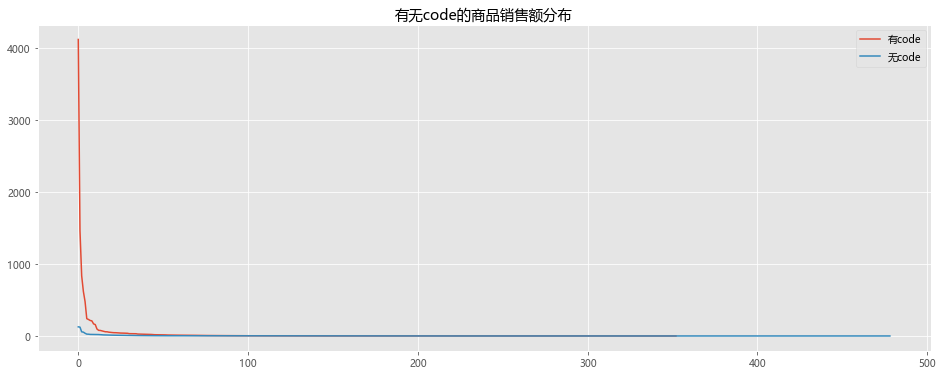

In [12]:
import matplotlib.pyplot as plt

# 无code的商品销售额分布
a = df1[df1['category_code'].notnull()].groupby('category_id')['price'].sum().sort_values(ascending=False)
b = df1[df1['category_code'].isnull()].groupby('category_id')['price'].sum().sort_values(ascending=False)

a1 = {k: v / 10000 for k, v in enumerate(a)}
b1 = {k: v / 10000 for k, v in enumerate(b)}

plt.figure(figsize=(16, 6))

x1 = a1.keys()
y1 = a1.values()
x2 = b1.keys()
y2 = b1.values()
plt.title('有无code的商品销售额分布')

plt.plot(x1, y1, label='有code')
plt.plot(x2, y2, label='无code')
# plt.xlabel('编号')
# plt.ylabel('万')
plt.legend()

# 显示图形
plt.show()

因为该变量是分类变量。而且缺少code的商品仅占全部销售额的极小部分。不对数据进行补充也不会影响后续分析，因此不进行补充。

In [13]:
# 观察标签数量
print('category_id数量',len(df1['category_id'].unique()),'\n',
    'category_code数量',len(df1['category_code'].unique()),'\n',
    'product_id数量',len(df1['product_id'].unique()),'\n',
    'user_id数量',len(df1['user_id'].unique()))

category_id数量 829 
 category_code数量 124 
 product_id数量 20964 
 user_id数量 93823


# 数据清洗-格式转换
1.时间转化  
2.标签代码拆分

In [14]:
# 时间转换
df1['event_time'] = pd.to_datetime(df1['event_time'])
df1['year'] = df1['event_time'].dt.year
df1['month'] = df1['event_time'].dt.month
df1['day'] = df1['event_time'].dt.day
df1['hour'] = df1['event_time'].dt.hour
df1['weekday'] = df1['event_time'].dt.weekday+1
df1.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,year,month,day,hour,weekday
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171520.000000,electronics.tablet,samsung,162.010000,1515915625441993984.000000,24.000000,女,海南,2020,4,24,11,5
1,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171520.000000,electronics.tablet,samsung,162.010000,1515915625441993984.000000,24.000000,女,海南,2020,4,24,11,5
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997248.000000,electronics.audio.headphone,huawei,77.520000,1515915625447879424.000000,38.000000,女,北京,2020,4,24,14,5
3,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997248.000000,electronics.audio.headphone,huawei,77.520000,1515915625447879424.000000,38.000000,女,北京,2020,4,24,14,5
4,2020-04-24 19:16:21+00:00,2294584263154074236,2273948316817424439,2268105471367840000.000000,NaN,karcher,217.570000,1515915625443148032.000000,32.000000,女,广东,2020,4,24,19,5


In [15]:
df1['category_code'] = df1['category_code'].fillna('not')
# 因为商品最多只有3级标签,所以拆分成三列.
df2 =   df1['category_code'].str.split(".", n=2, expand=True)
df2.columns = ['category_code1','category_code2','category_code3']
df2['category_code1'] = df2['category_code1'].fillna('not')
df2['category_code2'] = df2['category_code2'].fillna('not')
df2['category_code3'] = df2['category_code3'].fillna('not')
df3 = pd.concat([df1,df2],axis = 1)
df3.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,year,month,day,hour,weekday,category_code1,category_code2,category_code3
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171520.000000,electronics.tablet,samsung,162.010000,1515915625441993984.000000,24.000000,女,海南,2020,4,24,11,5,electronics,tablet,not
1,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171520.000000,electronics.tablet,samsung,162.010000,1515915625441993984.000000,24.000000,女,海南,2020,4,24,11,5,electronics,tablet,not
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997248.000000,electronics.audio.headphone,huawei,77.520000,1515915625447879424.000000,38.000000,女,北京,2020,4,24,14,5,electronics,audio,headphone
3,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997248.000000,electronics.audio.headphone,huawei,77.520000,1515915625447879424.000000,38.000000,女,北京,2020,4,24,14,5,electronics,audio,headphone
4,2020-04-24 19:16:21+00:00,2294584263154074236,2273948316817424439,2268105471367840000.000000,not,karcher,217.570000,1515915625443148032.000000,32.000000,女,广东,2020,4,24,19,5,not,not,not


In [16]:
col1 = df3['category_code1'].unique()
col2 = df3['category_code2'].unique()
col3 = df3['category_code3'].unique()

lis = list(col1) + list(col2) + list(col3)
dic = collections.defaultdict(int)

for i in lis:
    dic[i] += 1

dic = {k:v for k,v in dic.items() if v > 1}
            
# 因本身所属类别不同,会有部分二级和三级标签重名.这样的重名,是正常的.可以不调整.
df3[df3['category_code3']== 'not']
df3.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,age,sex,local,year,month,day,hour,weekday,category_code1,category_code2,category_code3
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171520.000000,electronics.tablet,samsung,162.010000,1515915625441993984.000000,24.000000,女,海南,2020,4,24,11,5,electronics,tablet,not
1,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2268105426648171520.000000,electronics.tablet,samsung,162.010000,1515915625441993984.000000,24.000000,女,海南,2020,4,24,11,5,electronics,tablet,not
2,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997248.000000,electronics.audio.headphone,huawei,77.520000,1515915625447879424.000000,38.000000,女,北京,2020,4,24,14,5,electronics,audio,headphone
3,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2268105430162997248.000000,electronics.audio.headphone,huawei,77.520000,1515915625447879424.000000,38.000000,女,北京,2020,4,24,14,5,electronics,audio,headphone
4,2020-04-24 19:16:21+00:00,2294584263154074236,2273948316817424439,2268105471367840000.000000,not,karcher,217.570000,1515915625443148032.000000,32.000000,女,广东,2020,4,24,19,5,not,not,not


# 描述性分析—平台销售数据统计
1.单件销售额  
2.单类销售额  
3.单件销售量  
4.单类销售量  
5.销售额

销量前20%的商品销售额占了总销售额的93.96%


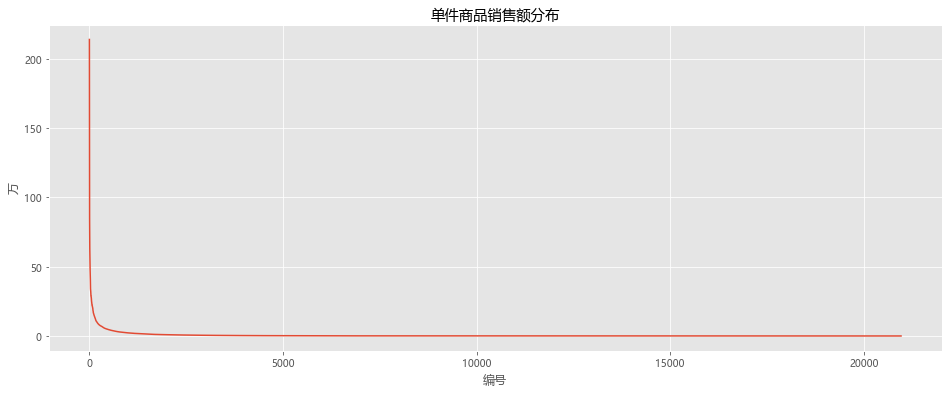

In [17]:
# 单件商品销售额分布
a = df3.groupby('product_id')['price'].sum().sort_values(ascending = False)
a1 = {k:v/10000 for k,v in enumerate(a)}

plt.figure(figsize=(16, 6))
           
x = a1.keys()
y = a1.values()
plt.title('单件商品销售额分布') 
plt.xlabel('编号') 
plt.ylabel('万') 
plt.plot(x,y)

a.max()
a_lis = list(a)
# print(a[:int(len(a_lis)*0.2)])
rate = format(sum(a[:int(len(a_lis)*0.2)]) / sum(a_lis)*100,'.2f')
print(f'销量前20%的商品销售额占了总销售额的{rate}%')
# 大致符合28定律.

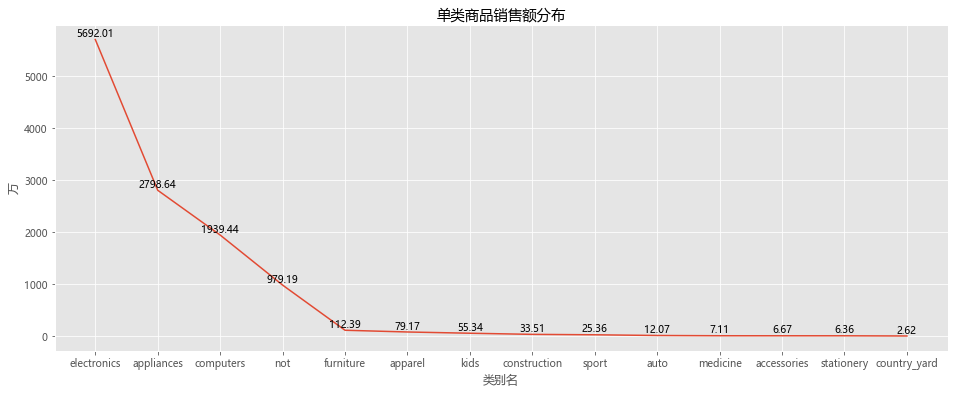

In [18]:
# 单类商品销售额分布情况
a = df3.groupby('category_code1')['price'].sum().sort_values(ascending = False)
a1 = {k:v/10000 for k,v in a.items()}

plt.figure(figsize=(16, 6))
# plt.xticks(range(0,len(a),20))
           
x = a1.keys()
y = a1.values()
plt.title('单类商品销售额分布') 
plt.xlabel('类别名') 
for i, j in zip(x, y):
    plt.text(i, j, str(format(j,'.2f')), ha='center', va='bottom')

plt.ylabel('万') 
plt.plot(x,y)
# 可以看出,前33个类别的销售额约10000万.即平台的主要销售额都为这三类商品.选取这三类数据,分别观察其中销售分布情况

销量前20%的商品销售额占了总销售量的83.93%


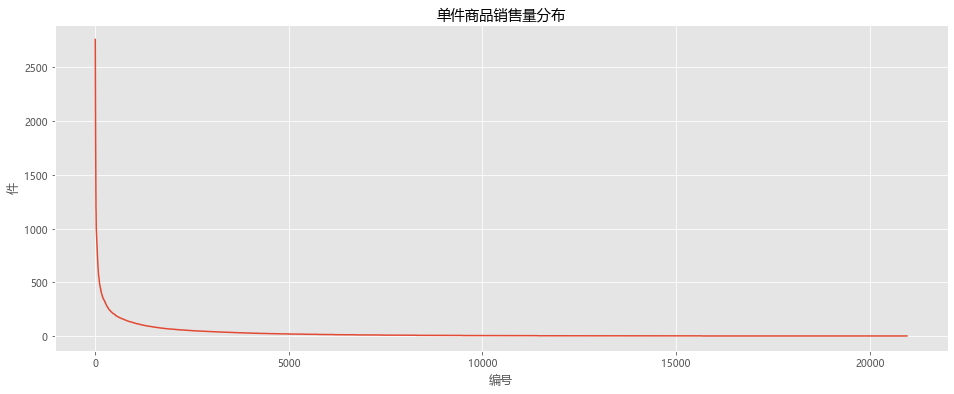

In [19]:
# 单件商品销售量分布
a = df3.groupby('product_id')['user_id'].count().sort_values(ascending = False)
a1 = {k:v for k,v in enumerate(a)}

plt.figure(figsize=(16, 6))
# plt.xticks(range(0,len(a),20))
           
x = a1.keys()
y = a1.values()
plt.title('单件商品销售量分布') 
plt.xlabel('编号') 

plt.ylabel('件') 
plt.plot(x,y)

a.max()
a_lis = list(a)
# print(a[:int(len(a_lis)*0.2)])
rate = format(sum(a[:int(len(a_lis)*0.2)]) / sum(a_lis)*100,'.2f')
print(f'销量前20%的商品销售额占了总销售量的{rate}%')

In [20]:
a = df3.groupby(['product_id','category_code'])['user_id'].count().sort_values(ascending = False)[:10]
a

product_id           category_code              
1515966223517846928  electronics.smartphone         2759
1515966223509106786  electronics.smartphone         2600
1515966223509088613  electronics.audio.headphone    2556
1515966223509088532  electronics.smartphone         2550
1515966223509088567  electronics.smartphone         2497
1515966223510174551  electronics.smartphone         2370
1515966223509088521  electronics.smartphone         2156
1515966223509104145  electronics.smartphone         2037
1515966223509088639  electronics.smartphone         1904
1515966223509117074  not                            1807
Name: user_id, dtype: int64

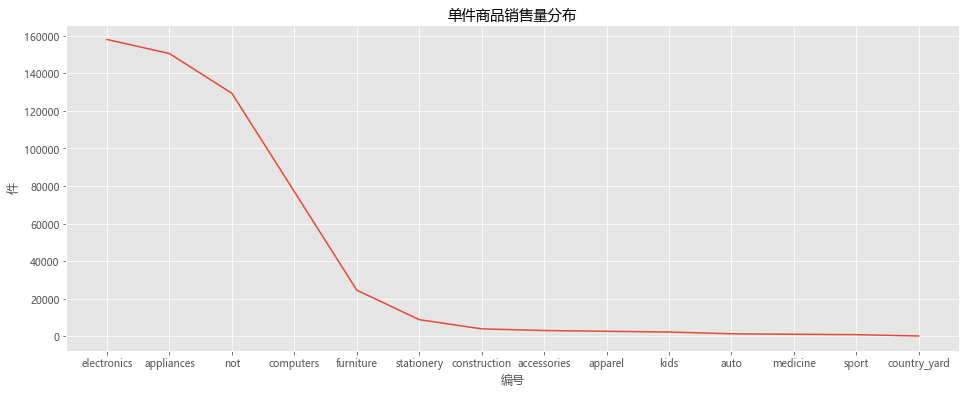

In [21]:
# 单类商品销售量分布情况

a = df3.groupby('category_code1')['user_id'].count().sort_values(ascending = False)
a1 = {k:v for k,v in a.items()}

plt.figure(figsize=(16, 6))
# plt.xticks(range(0,len(a),20))
           
x = a1.keys()
y = a1.values()
plt.title('单件商品销售量分布') 
plt.xlabel('编号') 

plt.ylabel('件') 
plt.plot(x,y)

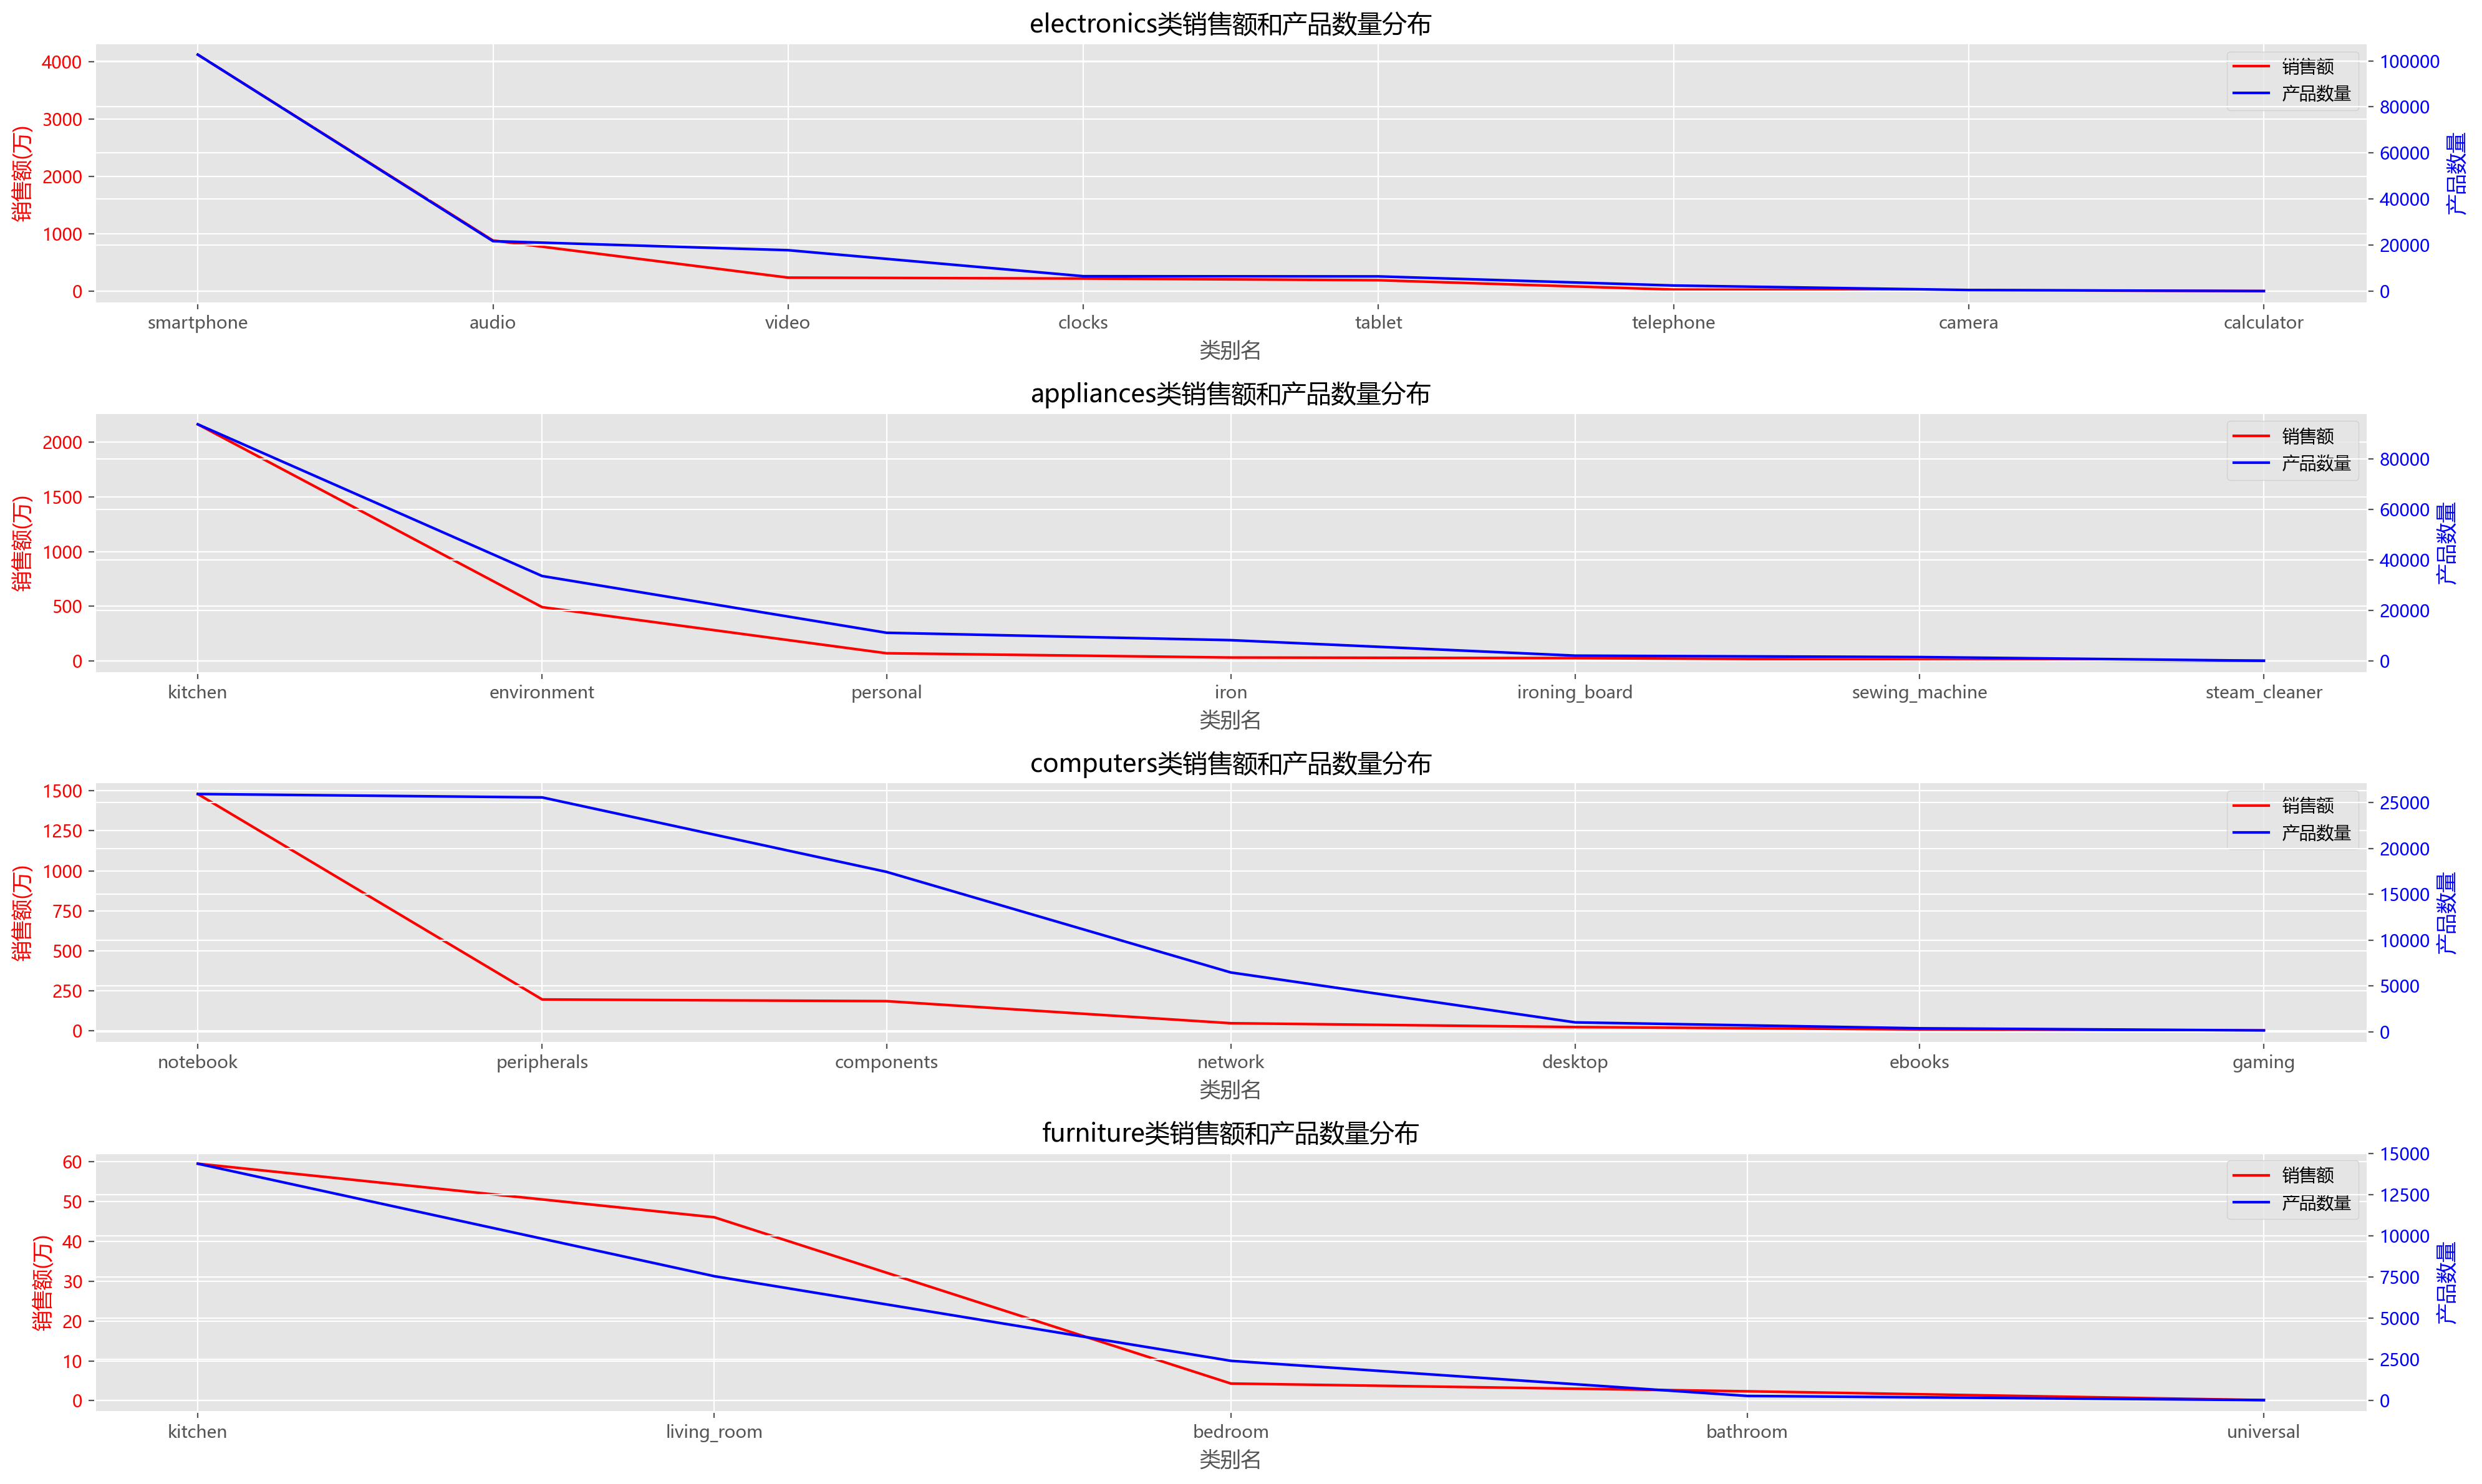

In [22]:
# 各类商品标签的销售和销量对比
temp_List = ['electronics', 'appliances', 'computers', 'furniture']
fig, axs = plt.subplots(nrows=len(temp_List), ncols=1, figsize=(20, 12), dpi=200)

for i in range(len(temp_List)):
    df_temp = df3[df3['category_code1'] == temp_List[i]]
    a = df_temp.groupby('category_code2')['price'].sum().sort_values(ascending=False)
    b = df_temp.groupby('category_code2')['product_id'].count().sort_values(ascending=False)
    a1 = {k: v/10000 for k, v in a.items()}
    b1 = {k: v for k, v in b.items()}

    x1 = list(a1.keys())
    y1 = list(a1.values())
    x2 = list(b1.keys())
    y2 = list(b1.values())

    axs[i].plot(range(len(x1)), y1, label='销售额', color='red')
    axs[i].set_xticks(range(len(x1)))
    axs[i].set_xticklabels(x1)
    axs[i].set_xlabel('类别名')
    axs[i].set_ylabel('销售额(万)', color='red')
    axs[i].tick_params(axis='y', labelcolor='red')

    ax2 = axs[i].twinx()
    ax2.plot(range(len(x2)), y2, label='产品数量', color='blue')
    ax2.set_xticks(range(len(x2)))
    ax2.set_xticklabels(x2)
    ax2.set_ylabel('产品数量', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    lines = [axs[i].get_lines()[0], ax2.get_lines()[0]]
    labels = [line.get_label() for line in lines]
    axs[i].legend(lines, labels)

    axs[i].set_title(f'{temp_List[i]}类销售额和产品数量分布')

plt.tight_layout()
plt.show()
# 如图所示,销量前4和销售额前4的类别基本保持一致.
# 前两类标签的销售额和销售量有比较明显的正相关趋势.

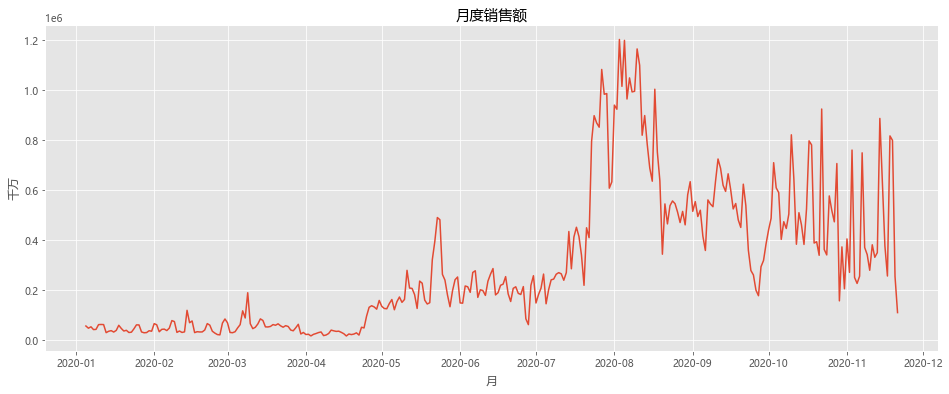

In [23]:
# 单类商品销售量分布情况
#存在异常值 18587 通过观察原始数据发现是订单年份为1970导致的问题.分组输出数据,查看是否还有其他异常年份.
df3.groupby(['year']).count()
# 异常年份只有一个1970,其余订单都是在2020年产生的,因此有理由相信这些异常数据也是在2020年产生的.

# 因为数据量占比不大,因此剔除这部分数据.
condition = df3[df3['year'] != 2020]
df3 = df3.drop(condition.index)

df4 = df3.copy()
df4 = df4.drop_duplicates(subset=['user_id','order_id'])
df4['event_time'] = df4['event_time'].dt.date

a = df4.groupby('event_time')['price'].sum()
a1 = {k:v for k,v in a.items()}

plt.figure(figsize=(16, 6))
           
x = a1.keys()
y = a1.values()
plt.title('月度销售额') 
plt.xlabel('月') 

plt.ylabel('千万') 
plt.plot(x,y)

# 用户分层

In [24]:
# 计算RMF值
df_user = df3.loc[:,['event_time','price','order_id','user_id','sex','age','local', 'category_code1']]
df_user['event_time_'] = df3['event_time'].dt.date
today = df_user['event_time_'].max()
col1 = df_user.groupby(['user_id'])['event_time_'].apply(lambda x:(today - max(x)).days).rename('R')
col2 = df_user.groupby(['user_id'])['price'].sum().rename('M')
col3 = pd.Series(df_user.groupby(['user_id'])['order_id'].nunique().values,name = 'F', index=df_user.groupby('user_id').groups.keys())
col4 = df_user.groupby(['user_id'])['event_time_'].max().rename('final_')
col5 = df_user.groupby(['user_id'])['event_time_'].min().rename('frist_')

df_user_table = pd.concat([col1,col2,col3,col4,col5],axis =1 )
df_user_table.sort_values(by='R',ascending=False).head()

,R,M,F,final_,frist_
1515915625479887104.000000,321,12.040000,1,2020-01-05,2020-01-05
1515915625447065600.000000,321,134.210000,1,2020-01-05,2020-01-05
1515915625462967808.000000,321,62.870000,1,2020-01-05,2020-01-05
1515915625481937408.000000,321,18.500000,1,2020-01-05,2020-01-05
1515915625466963200.000000,321,2.290000,1,2020-01-05,2020-01-05


In [25]:
df_user_table1 =df_user_table.loc[:,['R','M','F']]

def km(data):
    K = range(2, 10) # K值选取范围
    X = data # 数据
    # scores = { 'SSE': [], 'sc': [], 'sse': []}
    scores = {'sc': [], 'sse': []}
    for _k in K:
        # 初始化模型并进行聚类 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        scaler = StandardScaler()  # 标准化数据集
        X = scaler.fit_transform(X)  # 拟合并标准化数据集
        
        kmeans = KMeans(n_clusters=_k, init='k-means++', random_state=0)
        kmeans.fit(X)
        
        _y = kmeans.predict(X) # 预测结果
        # 计算模型评估指标 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        sse = sum(np.min(cdist(X,kmeans.cluster_centers_,'euclidean'),axis=1))/X.shape[0]
        sc = metrics.silhouette_score(X, _y) # 计算轮廓系数

        scores['sse'].append(sse)
        scores['sc'].append(sc)
    return scores


In [26]:
user_score = km(df_user_table1)

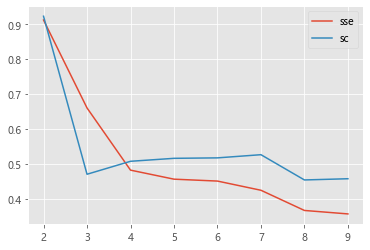

In [27]:
# draw([str(x) for x in range(2,10)], user_score['sse'], user_score['sc']).render_notebook()

x1 = range(2,10)
y1 = user_score['sse']

x2 = range(2,10)
y2 = user_score['sc']

plt.plot(x1,y1,label = 'sse')
plt.plot(x2,y2,label = 'sc')
plt.legend()
plt.xlabel = '簇数'
plt.ylabel = '得分'

In [28]:
kmeans = KMeans(n_clusters= 4, init='k-means++', random_state=0)
kmeans.fit(df_user_table1)
df_user_table1['分类标签'] = kmeans.predict(df_user_table1)

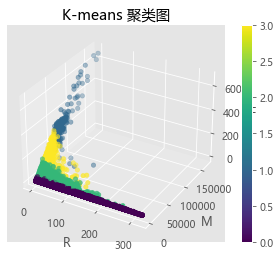

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_user_table1['R'], df_user_table1['M'], df_user_table1['F'], c=df_user_table1['分类标签'], cmap='viridis')

# 设置标题和坐标轴标签
ax.set_title('K-means 聚类图')
ax.set_xlabel('R')
ax.set_ylabel('M')
ax.set_zlabel('F')

# 创建颜色图例
colorbar = plt.colorbar(scatter)

# 显示图形
plt.show()

In [30]:
df_user_table1.groupby('分类标签').agg(['mean','count'])

R                     M                     F       
               mean  count           mean  count           mean  count
分类标签                                                                  
0        101.709374  88041     669.778545  88041       2.404914  88041
1          3.502304    217   66879.158756    217     296.857143    217
2         51.730355   5103    6010.148693   5103      13.530276   5103
3         12.258929    448   29396.576094    448     121.776786    448

In [31]:
df_user_table1.describe()

# R值取30天内有活跃的为高.即最近一个月有过消费记录的
# M值取460以上为高,消费金额50%分位
# F值取4次以上为高,消费次数均值.
r = [322,30] # 1是高 0 是低
f = [6660,4] # 1是低 0是高
m = [170000,460] # 1是低 0 是高

rfm = [r,f,m]

dic = {'011':'潜在客户','001':'一般保持客户','010':'重点挽留客户','100':'高价值客户',
       '110':'重点发展客户','101':'一般价值客户','000':'重点保持客户','111':'一般发展客户'}
    
def check_rmf(x):
    r1 = ''
    m1 = ''
    f1 = ''
    for i in range(2):
        if x[0] < rfm[0][i]:
            r1 =  str(i)
        if x[1] < rfm[1][i]:
            f1 = str(i)
        if x[2] < rfm[2][i]:
            m1 = str(i)

    return dic[r1+f1+m1]

df_user_table1['RMF标签'] = df_user_table1.apply(lambda x:check_rmf([x['R'],x['F'],x['M']]),axis = 1)

In [32]:
a = df_user_table1.groupby('RMF标签')['分类标签'].count()
user_label = {'一般价值客户': ['高','高','低'], '一般保持客户': ['低','高','低'], '一般发展客户': ['高','低','低'], '潜在客户': ['低','低','低'],
 '重点保持客户': ['低','高','高'], '重点发展客户': ['高','低','高'], '重点挽留客户': ['低','低','高'], '高价值客户': ['高','高','高']}

df_user_lable_table = pd.DataFrame({'RMF标签':list(a.keys()),
                                    'RMF人数':list(a),
                                    'R':['高', '低', '高', '低', '低', '高', '低', '高'],
                                    'F':['高', '高', '低', '低', '高', '低', '低', '高'],
                                    'M':['低', '低', '低', '低', '高', '高', '高', '高'],
                                    '用户等级':['C','C','C','D','B','B','B','A',]})

df_user_lable_table = df_user_lable_table.sort_values(by='用户等级')
df_user_lable_table

,RMF标签,RMF人数,R,F,M,用户等级
7,高价值客户,5538,高,高,高,A
4,重点保持客户,15020,低,高,高,B
5,重点发展客户,2861,高,低,高,B
6,重点挽留客户,23488,低,低,高,B
0,一般价值客户,300,高,高,低,C
1,一般保持客户,1651,低,高,低,C
2,一般发展客户,3117,高,低,低,C
3,潜在客户,41834,低,低,低,D


<BarContainer object of 8 artists>

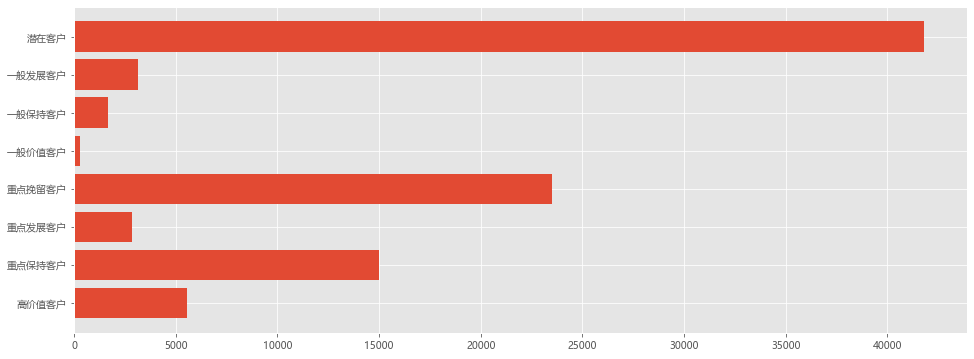

In [33]:
# 统计人数
x = list(df_user_lable_table['RMF标签'])
y = list(df_user_lable_table['RMF人数'])

plt.figure(figsize=(16, 6))
plt.barh(x,y)

In [34]:
df_user_table1 = df_user_table1.reset_index()
df_user_table1.columns=['user_id','R', 'M', 'F', '标签', 'RMF标签']

In [35]:
df_user1 = df_user.loc[:,['price','user_id', 'sex', 'age', 'local','category_code1',]]
# 汇总所有用户信息
df3 = pd.merge(df_user_table1,df3,how ='left',on='user_id') 

# 用户活跃程度分层和每日新增用户
各用户定义  
1.新用户，当日首次购买  
2.活跃用户，每月超过3次购买  
3.普通用户，每月一次购买  
4.沉睡用户，超30天未购买  
5.回流用户，距离上一次购买已经超过60天  
6.流失用户，超60天未购买  

In [36]:
user_life_time = df3.loc[:,['event_time','order_id','user_id','sex','age','year', 'month', 'day', 'weekday','hour']]
user_life_time['order_day'] = user_life_time['event_time'].dt.date
user_life_time['today'] = user_life_time['order_day'].max()  

In [37]:
user_life_time.columns

Index(['event_time', 'order_id', 'user_id', 'sex', 'age', 'year', 'month',
       'day', 'weekday', 'hour', 'order_day', 'today'],
      dtype='object')

In [38]:
col1 = user_life_time.groupby(['user_id','order_day','hour', 'month','year', 'day','today'])['order_id'].count().rename('daily_order_cnt')
col1 = col1.reset_index()
col2 = col1.groupby(['user_id'])['order_day'].shift(-1).rename('next_day') # 用户的下一次购买时间
col3 = col1.groupby(['user_id'])['order_day'].shift().rename('last_day') # 用户的上一次购买时间
user_life_time_table0 = pd.concat([col1,col2,col3],axis =1 ).reset_index()

user_life_time_table0['next_day'].fillna(today,inplace=True)
user_life_time_table0['last_day'].fillna(user_life_time_table0['order_day'],inplace=True)

In [39]:
user_life_time_table0.head()

,index,user_id,order_day,hour,month,year,day,today,daily_order_cnt,next_day,last_day
0,0,1515915625439951872.000000,2020-07-09,6,7,2020,9,2020-11-21,1,2020-11-21,2020-07-09
1,1,1515915625440038400.000000,2020-09-22,15,9,2020,22,2020-11-21,1,2020-10-28,2020-09-22
2,2,1515915625440038400.000000,2020-10-28,5,10,2020,28,2020-11-21,1,2020-11-21,2020-09-22
3,3,1515915625440051712.000000,2020-10-21,12,10,2020,21,2020-11-21,1,2020-10-23,2020-10-21
4,4,1515915625440051712.000000,2020-10-23,3,10,2020,23,2020-11-21,1,2020-10-23,2020-10-21


In [40]:
user_life_time_table0['order_day'] = pd.to_datetime(user_life_time_table0['order_day'])

# 计算每个用户的最早和最晚订单日期
col1 = user_life_time_table0.groupby('user_id')['order_day'].max().reset_index(name='finaly_')
col2 = user_life_time_table0.groupby('user_id')['order_day'].min().reset_index(name='frist_')

# 合并结果
user_life_time_table1 = pd.merge(col1, col2, on='user_id')

In [41]:
user_life_time_table1.head()

,user_id,finaly_,frist_
0,1515915625439951872.000000,2020-07-09,2020-07-09
1,1515915625440038400.000000,2020-10-28,2020-09-22
2,1515915625440051712.000000,2020-11-16,2020-10-21
3,1515915625440099840.000000,2020-11-08,2020-05-12
4,1515915625440121600.000000,2020-07-14,2020-05-16


In [42]:
user_life_time_table = pd.merge(user_life_time_table0,user_life_time_table1,on='user_id')

In [43]:
user_life_time_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293740 entries, 0 to 293739
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            293740 non-null  int64         
 1   user_id          293740 non-null  float64       
 2   order_day        293740 non-null  datetime64[ns]
 3   hour             293740 non-null  int64         
 4   month            293740 non-null  int64         
 5   year             293740 non-null  int64         
 6   day              293740 non-null  int64         
 7   today            293740 non-null  object        
 8   daily_order_cnt  293740 non-null  int64         
 9   next_day         293740 non-null  object        
 10  last_day         293740 non-null  object        
 11  finaly_          293740 non-null  datetime64[ns]
 12  frist_           293740 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(6), object(3)
memory usage: 31.4+ 

In [44]:
# 如果向右偏移之后值为nan的，说明用户在购买了一单之后就再无购买记录了，因此以今天的时间为填充。

user_life_time_table['order_day'] = pd.to_datetime(user_life_time_table['order_day'])
user_life_time_table['next_day'] = pd.to_datetime(user_life_time_table['next_day'], errors='coerce')
user_life_time_table['next_order'] = (user_life_time_table['next_day'] - user_life_time_table['order_day']).dt.days

user_life_time_table['last_day'] = pd.to_datetime(user_life_time_table['last_day'], errors='coerce')
user_life_time_table['last_order'] = (user_life_time_table['order_day'] - user_life_time_table['last_day']).dt.days

# user_life_time_table['last_order'].astype('int')

In [45]:
user_life_time_table.head()

,index,user_id,order_day,hour,month,year,day,today,daily_order_cnt,next_day,last_day,finaly_,frist_,next_order,last_order
0,0,1515915625439951872.000000,2020-07-09,6,7,2020,9,2020-11-21,1,2020-11-21,2020-07-09,2020-07-09,2020-07-09,135,0
1,1,1515915625440038400.000000,2020-09-22,15,9,2020,22,2020-11-21,1,2020-10-28,2020-09-22,2020-10-28,2020-09-22,36,0
2,2,1515915625440038400.000000,2020-10-28,5,10,2020,28,2020-11-21,1,2020-11-21,2020-09-22,2020-10-28,2020-09-22,24,36
3,3,1515915625440051712.000000,2020-10-21,12,10,2020,21,2020-11-21,1,2020-10-23,2020-10-21,2020-11-16,2020-10-21,2,0
4,4,1515915625440051712.000000,2020-10-23,3,10,2020,23,2020-11-21,1,2020-10-23,2020-10-21,2020-11-16,2020-10-21,0,2


# 用户复购分析

In [46]:
user_life_time_table_ = user_life_time_table[(user_life_time_table['next_order'] !=0) &
                                             (user_life_time_table['order_day'] == user_life_time_table['frist_']) &
                                             (user_life_time_table['order_day'] != user_life_time_table['finaly_'])]

In [47]:
user_life_time_table_.head()

,index,user_id,order_day,hour,month,year,day,today,daily_order_cnt,next_day,last_day,finaly_,frist_,next_order,last_order
1,1,1515915625440038400.000000,2020-09-22,15,9,2020,22,2020-11-21,1,2020-10-28,2020-09-22,2020-10-28,2020-09-22,36,0
3,3,1515915625440051712.000000,2020-10-21,12,10,2020,21,2020-11-21,1,2020-10-23,2020-10-21,2020-11-16,2020-10-21,2,0
8,8,1515915625440099840.000000,2020-05-12,5,5,2020,12,2020-11-21,1,2020-05-21,2020-05-12,2020-11-08,2020-05-12,9,0
25,25,1515915625440121600.000000,2020-05-16,16,5,2020,16,2020-11-21,1,2020-07-14,2020-05-16,2020-07-14,2020-05-16,59,0
27,27,1515915625440881408.000000,2020-05-20,17,5,2020,20,2020-11-21,1,2020-07-23,2020-05-20,2020-11-16,2020-05-20,64,0


In [48]:
# 有两次以上购买的用户，一般间隔多久复购。
fugou = user_life_time_table_['next_order'].value_counts().sort_index()
# 可以看出，复购一般出现在出现订单后天内

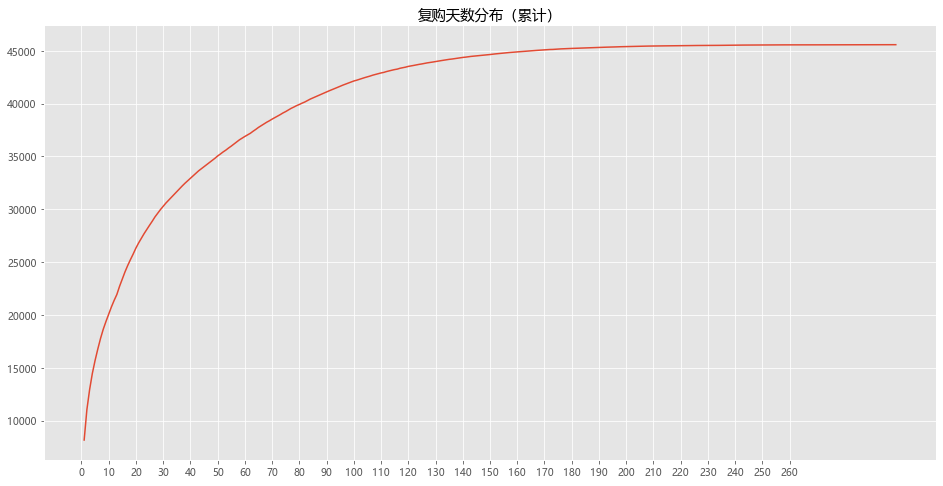

In [49]:
x = list(fugou.index)
y = list(fugou)

# 计算累计值
y_cumulative = np.cumsum(y)

plt.figure(figsize=(16, 8))
plt.plot(x, y_cumulative)
plt.xticks(range(0, len(x) + 1, 10))
plt.title('复购天数分布（累计）')
plt.show()

可以看出，有20000次复购在10天以内。35000次复购在50天内。

In [50]:
# 将 order_day 列转换为 datetime 类型
user_life_time_table['order_day'] = pd.to_datetime(user_life_time_table['order_day'])
user_life_time_table['today'] = pd.to_datetime(user_life_time_table['today'])  
# 根据 user_id 和 order_day 对数据框进行分组，并计算每天的订单数量
daily_order_counts = user_life_time_table.groupby(['user_id', 'order_day'])['daily_order_cnt'].count().reset_index()

# 对每个用户应用滚动窗口,统计30天内的购买量
def apply_rolling(df):
    df = df.set_index('order_day')
    df['rolling_30d_order_cnt'] = df['daily_order_cnt'].rolling(window='30D', min_periods=1).sum()
    return df.reset_index()

daily_order_counts = daily_order_counts.groupby('user_id').apply(apply_rolling).reset_index(drop=True)

daily_order_counts.head()

,order_day,user_id,daily_order_cnt,rolling_30d_order_cnt
0,2020-07-09,1515915625439951872.000000,1,1.000000
1,2020-09-22,1515915625440038400.000000,1,1.000000
2,2020-10-28,1515915625440038400.000000,1,1.000000
3,2020-10-21,1515915625440051712.000000,1,1.000000
4,2020-10-23,1515915625440051712.000000,3,4.000000


In [51]:
# daily_order_counts.columns
user_life_time_table.columns

Index(['index', 'user_id', 'order_day', 'hour', 'month', 'year', 'day',
       'today', 'daily_order_cnt', 'next_day', 'last_day', 'finaly_', 'frist_',
       'next_order', 'last_order'],
      dtype='object')

In [52]:
user_life_time_table = pd.merge(user_life_time_table,daily_order_counts,on=['order_day', 'user_id', 'daily_order_cnt' ])

In [53]:
# user_life_time_table.head()

# user_life_time_table[user_life_time_table['user_id'] == 1515915625440038400.000000]

In [54]:
# 各用户定义 
# 1.新用户，用户首次购买  
# 2.活跃用户，每月超过3次购买  
# 3.普通用户，每月一次购买  
# 4.正常用户，每月一次购买
# 5.沉睡用户，超30天未购买  
# 6.回流用户，距离上一次购买已经超过60天  
# 7.流失用户，超60天未购买  

user_life_time_table['today'] = pd.to_datetime(user_life_time_table['today'])  
(user_life_time_table['finaly_'] - user_life_time_table['order_day']).dt.days
user_life_time_table.info()
# user_life_time_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163393 entries, 0 to 163392
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  163393 non-null  int64         
 1   user_id                163393 non-null  float64       
 2   order_day              163393 non-null  datetime64[ns]
 3   hour                   163393 non-null  int64         
 4   month                  163393 non-null  int64         
 5   year                   163393 non-null  int64         
 6   day                    163393 non-null  int64         
 7   today                  163393 non-null  datetime64[ns]
 8   daily_order_cnt        163393 non-null  int64         
 9   next_day               163393 non-null  datetime64[ns]
 10  last_day               163393 non-null  datetime64[ns]
 11  finaly_                163393 non-null  datetime64[ns]
 12  frist_                 163393 non-null  date

In [55]:
def check_grade_frist(order_day,frist_):  # order_day,frist_,today,last_day,rolling_30d_order_cnt
    if order_day == frist_: # 如果第一单时间和当天时间保持一致,就是新用户
        return 1
    else:
        return 0
    
def check_grade_lost(today,finaly_,order_day): 
    days_difference = (today - finaly_ ).days
    if days_difference >= 60 and finaly_ == order_day:  # 
        return  '流失用户'
    
    elif days_difference >= 30: # 
        return  '沉睡用户'    
    
    else:
        return  '正常用户'

    
def check_grade_finaly(last_order):  # order_day,frist_,today,last_day,rolling_30d_order_cnt
      # 今日距离订单日期的差额
    if last_order <= 30:  # 下一订单日期距离当日不超过30天
        return  '普通用户'
    
    elif last_order >= 60:
        return  '回流用户'

def check_grade_live(rolling_30d_order_cnt):  # order_day,frist_,today,last_day,rolling_30d_order_cnt
    if rolling_30d_order_cnt >= 3: # 如果第一单时间和当天时间保持一致,就是新用户
        return '1'  # 活跃用户
    else : 
        return '0'  # 普通用户

user_life_time_table['是否新增'] = user_life_time_table.apply(
    lambda x: check_grade_frist(x['order_day'],x['frist_']),axis=1)

user_life_time_table['活跃程度—购买量'] = user_life_time_table.apply(
    lambda x: check_grade_live(x['rolling_30d_order_cnt']),axis=1)

user_life_time_table['活跃标签'] = user_life_time_table.apply(
    lambda x: check_grade_finaly(x['last_order']),axis=1)

user_life_time_table['活跃程度—流失情况'] = user_life_time_table.apply(
    lambda x: check_grade_lost(x['today'],x['finaly_'],x['order_day']),axis=1)

# 用户行为的时间分布

In [56]:
# 使用 apply 函数计算 order_day 列中的日期是否为工作日
user_life_time_table['is_workday'] = user_life_time_table['order_day'].apply(
    lambda x: np.is_busday(x.strftime('%Y-%m-%d'))
).replace({True:1,False:0})

In [57]:
temp = user_life_time_table.groupby(['is_workday'])['hour'].value_counts().unstack()

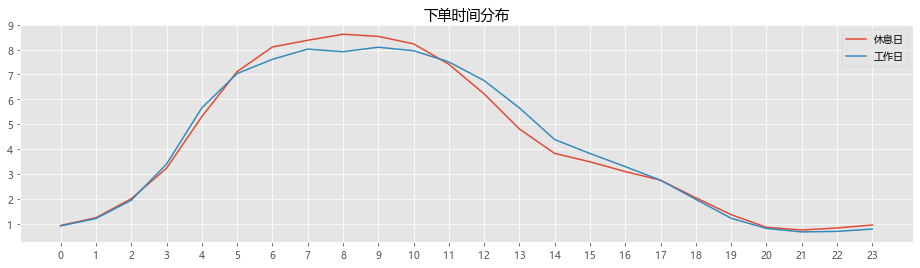

In [58]:
a = temp.iloc[0] # 休息日
b = temp.iloc[1] # 工作日

plt.figure(figsize = (16,4))

x1 = list(a.keys())
y1 = list([i/sum(a)*100 for i in a])

x2 = list(a.keys())
y2 = list([i/sum(b)*100 for i in b])

plt.plot(x1,y1, label = '休息日')
plt.plot(x2,y2, label = '工作日')
# plt.xlabel('小时')
# plt.ylabel('人数百分比(%)')
plt.xticks(x1)
plt.title('下单时间分布')
plt.legend()


In [59]:
# 订单下单时间集中在5点到13点间，工作日和休息日并无太大区别。

In [60]:
fina = user_life_time_table.drop_duplicates(subset='user_id',keep='last')
fris = user_life_time_table.drop_duplicates(subset='user_id',keep='first')

In [61]:
c = fina.groupby('order_day')['活跃程度—流失情况'].value_counts().unstack(fill_value=0)
a = fris.groupby('order_day')['是否新增'].sum()
a = pd.DataFrame(a)
d = fina.groupby('order_day')['活跃标签'].value_counts().unstack(fill_value=0)
e = pd.concat([a,d,c],axis=1)
e.reset_index(inplace=True)

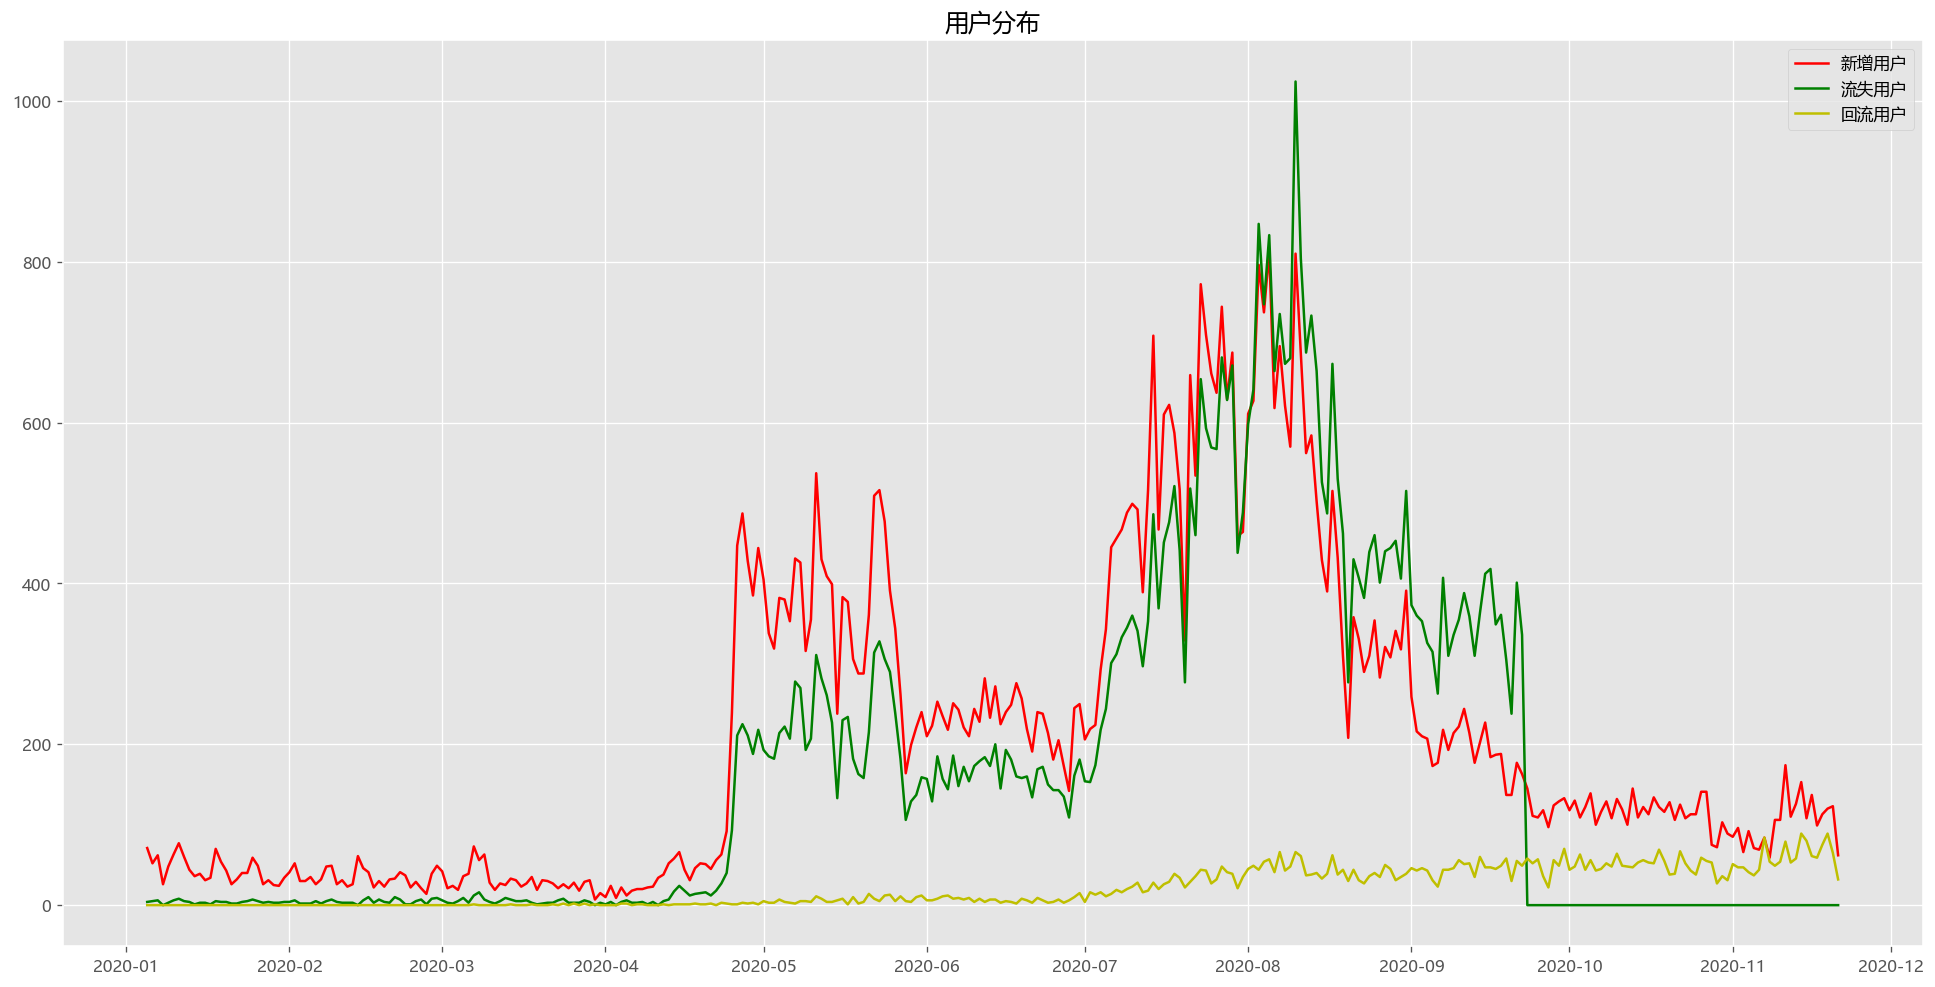

In [62]:
# 新增用户曲线图
plt.figure(figsize=(20, 10),dpi=120)

x1 = list(e['order_day'])
y1 = list(e['是否新增'])

x2 = list(e['order_day'])
y2 = list(e['流失用户'])

x3 = list(e['order_day'])
y3 = list(e['回流用户'])

plt.plot(x1,y1,color = 'r',label='新增用户')
plt.plot(x2,y2,color = 'g',label='流失用户')
plt.plot(x3,y3,color = 'y',label='回流用户')


plt.legend()

plt.title('用户分布')
# plt.xlabel('月份')
# plt.ylabel('人数（个）')
plt.show()

如图平台在前5个月的日新增用户在100人以下，相对比较低。
而5月到6月间，7月中旬到8月中旬这两个月新增人数是整年的两个高峰期。  平台的流失率比较高，每月的新增和流失近乎持平。尤其是在7月中旬到8月中旬的时候，流失用户比新增的更多。  
从侧面说明大多数用户的需求被满足后，便长时间不会在进入平台购物。需要多发掘用户的购物需求。

In [63]:
# 用户标签和销售额关联性

In [64]:
e1 = df4.groupby('event_time')['price'].sum()
e1 = e1.reset_index()
e1['event_time'] = pd.to_datetime(e1['event_time'])
e2 = pd.merge(e1,e,left_on='event_time',right_on='order_day')


Text(0.5, 1.0, '用户类型和销售额相关性')

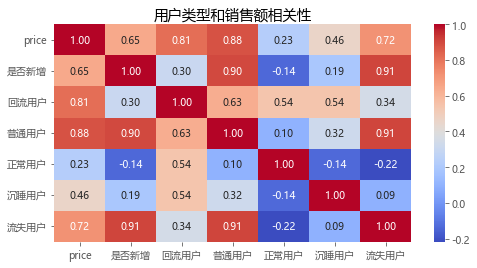

In [65]:
a = e2.corr()
plt.figure(figsize=(8,4))
sns.heatmap(a, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("用户类型和销售额相关性")

可以看出，平台销售额的增长和新增用户的相关性，还不如回流用户、普通用户关联性高。
说明平台销售额的主要贡献度还是来源于一般用户，而不是新增用户。平台想要提高销售额应该想办法让平台用户提高消费欲望。刺激消费。

In [66]:
e.describe()

,是否新增,回流用户,普通用户,正常用户,沉睡用户,流失用户
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,206.083851,21.031056,204.531056,33.183230,49.732919,161.285714
std,194.301503,23.308555,200.629245,96.326874,80.337315,211.617371
min,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,44.250000,0.000000,10.000000,0.000000,2.000000,2.000000
50%,132.500000,8.000000,186.500000,2.000000,25.000000,13.000000
75%,309.500000,43.000000,293.750000,9.000000,50.000000,281.000000
max,813.000000,89.000000,1019.000000,583.000000,383.000000,1024.000000


1.平台普通用户(近30天有购买记录)的只有1万出头,沉睡用户接近6万+,流失用户和回流用户都很低,说明最近用户在平台的购买欲望并不强.用户消费需求下降.  
2.当前平台沉睡用户占比很大。但流失用户很低，说明用户粘性比较强，但近期购买需求不强。结合一年内用户的标签情况做进一步分析。判断沉睡用户占比高是长期现象，还是短期现象。


# 用户购买推荐

借鉴推荐算法的思路：假设一个用户A喜欢A1视频，如果有和A类似的用户B在喜欢A1视频，同时也喜欢B1视频，那么可以认为用户A可能也会对B1视频有兴趣。（这里只统计了商品类别，实际上可能用产品ID效果更好。）
  
因此把所有用户的购买记录进行聚合。统计不同角色标签中用户购买的商品数。统计每件商品和其他商品出现的组合次数。  
寻找是否有一些商品总会被用户组合购买。 

In [67]:
df3

,user_id,R,M,F,标签,RMF标签,event_time,order_id,product_id,category_id,...,sex,local,year,month,day,hour,weekday,category_code1,category_code2,category_code3
0,1515915625439951872.000000,135,416.640000,1,0,潜在客户,2020-07-09 06:35:18+00:00,2349284169969828321,1515966223509089779,2374498914000592384.000000,...,女,浙江,2020,7,9,6,4,electronics,video,tv
1,1515915625440038400.000000,24,56.430000,2,0,一般发展客户,2020-09-22 15:11:15+00:00,2388440981134512449,2273948227747185446,2268105410592374784.000000,...,男,北京,2020,9,22,15,2,kids,toys,not
2,1515915625440038400.000000,24,56.430000,2,0,一般发展客户,2020-10-28 05:53:47+00:00,2388440981134640159,1515966223520144221,2268105409048871168.000000,...,男,北京,2020,10,28,5,3,computers,network,router
3,1515915625440051712.000000,5,7530.340000,5,2,高价值客户,2020-10-21 12:23:18+00:00,2388440981134625646,2309018185069757002,2268105455169438720.000000,...,男,广东,2020,10,21,12,3,not,not,not
4,1515915625440051712.000000,5,7530.340000,5,2,高价值客户,2020-10-23 03:51:26+00:00,2388440981134632037,1515966223509104210,2374498914000592384.000000,...,男,广东,2020,10,23,3,5,electronics,video,tv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562857,1515915625514888704.000000,0,752.490000,3,0,重点发展客户,2020-11-21 09:34:29+00:00,2388440981134693915,1515966223526602848,2268105428166508800.000000,...,男,上海,2020,11,21,9,6,electronics,smartphone,not
562858,1515915625514888704.000000,0,752.490000,3,0,重点发展客户,2020-11-21 09:50:11+00:00,2388440981134693924,1515966223510668566,2268105471267176704.000000,...,男,上海,2020,11,21,9,6,not,not,not
562859,1515915625514888704.000000,0,752.490000,3,0,重点发展客户,2020-11-21 10:10:01+00:00,2388440981134693942,1515966223526602848,2268105428166508800.000000,...,男,上海,2020,11,21,10,6,electronics,smartphone,not
562860,1515915625514891008.000000,0,925.670000,1,0,重点发展客户,2020-11-21 10:04:42+00:00,2388440981134693937,1515966223509088671,2268105428166508800.000000,...,女,上海,2020,11,21,10,6,electronics,smartphone,not


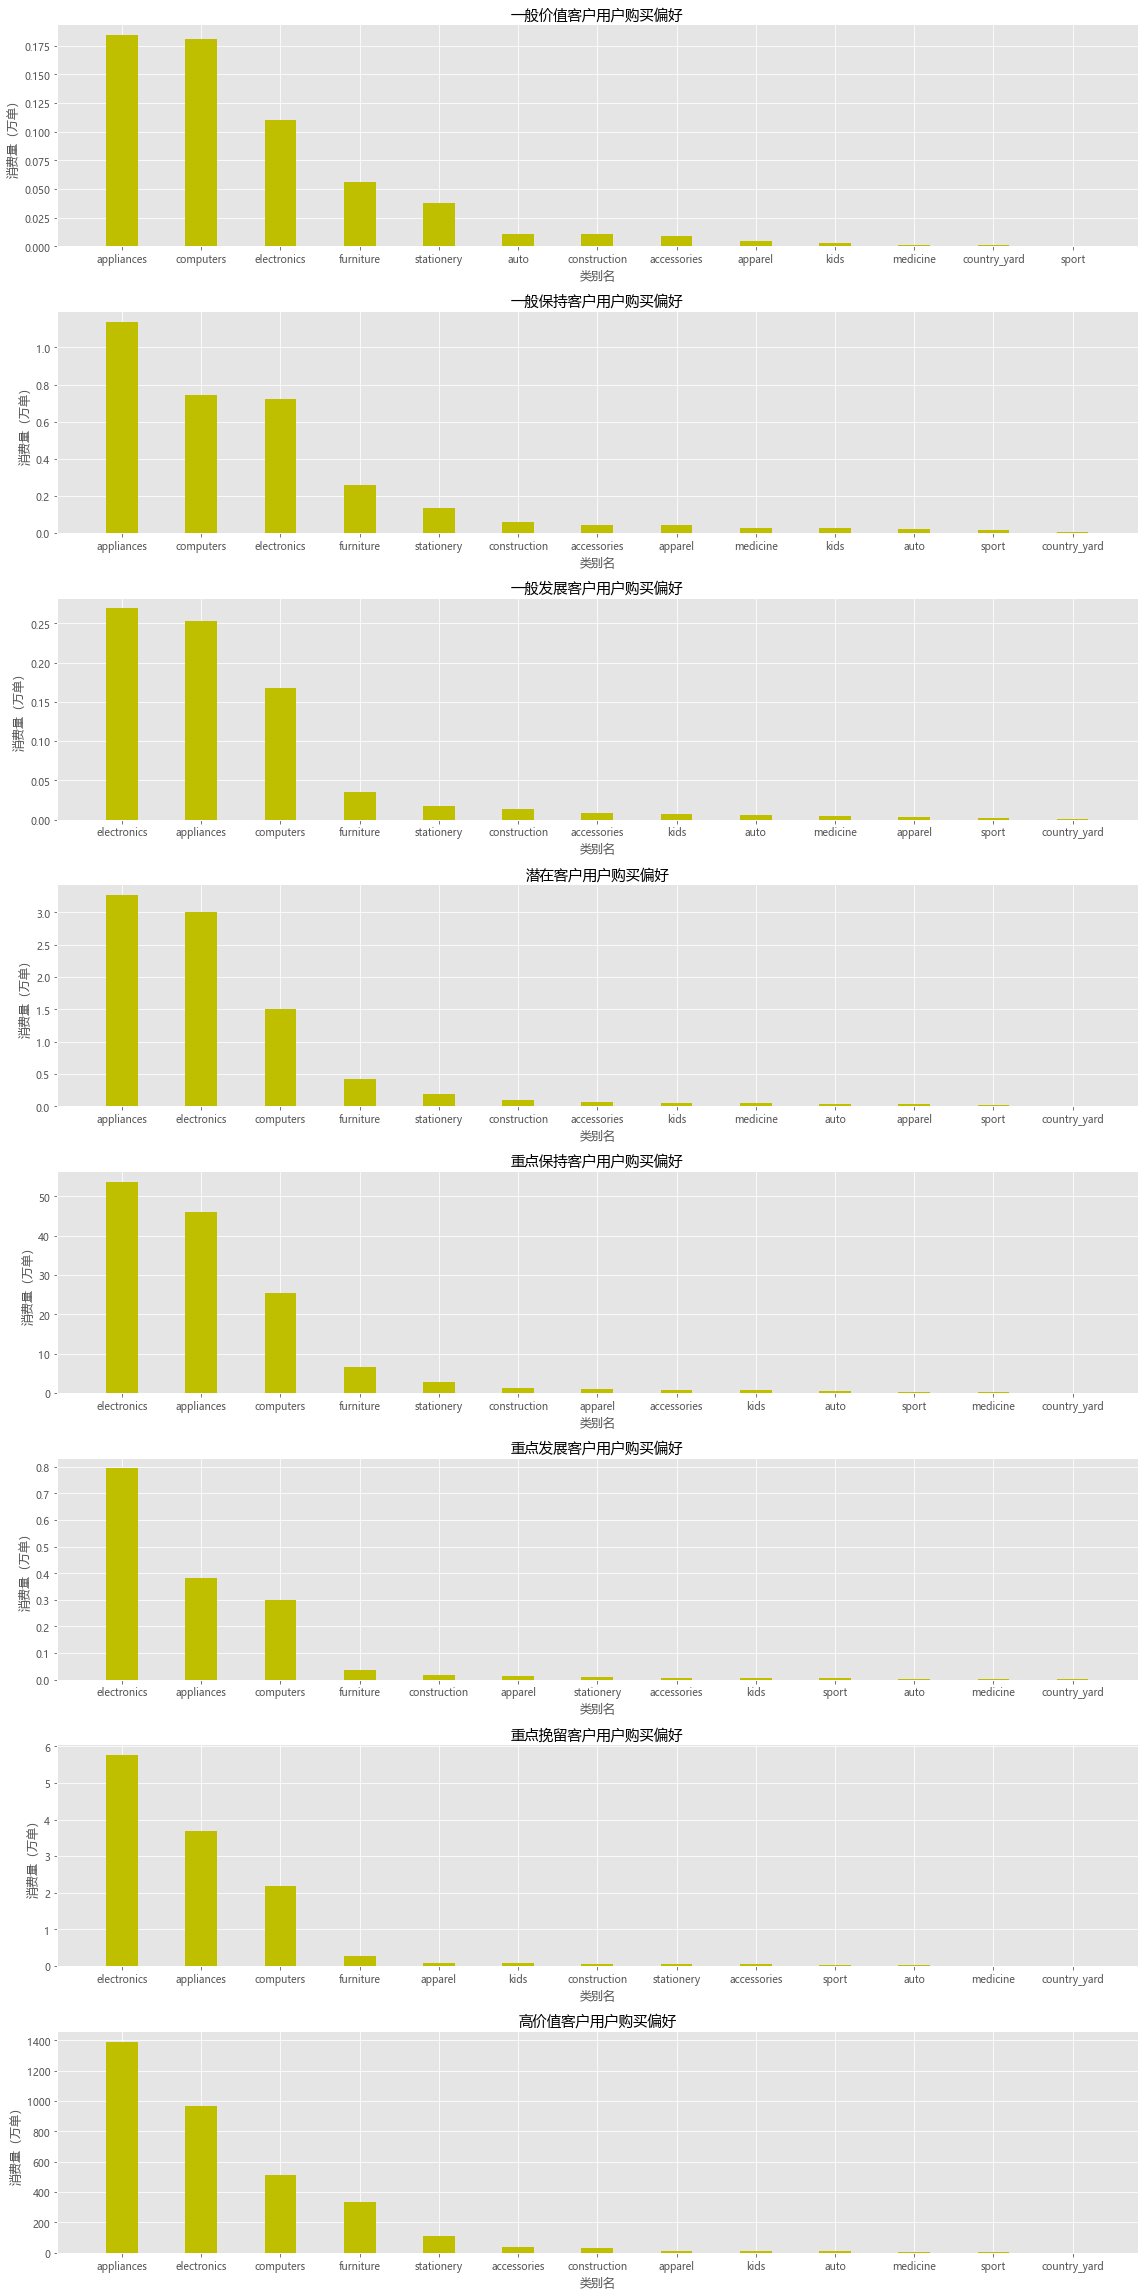

In [68]:
# 用户购买偏好的类别聚类
a = df3.groupby(['category_code1','RMF标签' ])['F'].sum().unstack(level=1)

lis = ['一般价值客户','一般保持客户','一般发展客户','潜在客户','重点保持客户','重点发展客户','重点挽留客户','高价值客户']

fig, axs = plt.subplots(nrows=len(lis), ncols=1, figsize=(16, 32))

for j in range(8):
    a1 = {k: v / 10000 for k, v in a[lis[j]].items()}
    a1 = sorted(a1.items() , key = lambda x:x[1],reverse=True)

    x1 = [i[0] for i in a1 if i[0] != 'not']
    y1 = [i[1] for i in a1 if i[0] != 'not']

    axs[j].bar(x1, y1,0.4, color = 'y')

    # 设置图形属性
    axs[j].set_xlabel('类别名')
    axs[j].set_ylabel('消费量（万单）')
    axs[j].set_title(f'{lis[j]}用户购买偏好')
    axs[j].set_xticks(x1)
    axs[j].set_xticklabels(x1)

plt.tight_layout()
plt.show()      

1.appliances,computes,electronics三类占据各分层的销售前三。但不同客户分层的用户在单类商品的购买偏好上，没有太大区别。说明用户主要使用平台购买电子产品为主。  
2.平台有12%左右的用户在近一个月内有购买记录。结合前边的活跃程度标签，说明当前平台不能很好的满足用户的购买需求。

In [69]:
# 用户购买偏好的商品聚类
df_dict_user = df3.groupby('user_id')['category_code1'].value_counts().to_dict()
result_dict = {}
# 用自定义函数把它放进单元格中.
for (user_id, category), count in df3.groupby(['user_id', 'category_code']).size().items():
    if user_id not in result_dict:
        result_dict[user_id] = {}
        # 筛选出每个用户出现过复购的商品（购买数超过2次）。
    #if count >= 2 and category != 'not':
    result_dict[user_id][category] = count
        
df_user_table1['result_dict'] = df_user_table1['user_id'].apply(lambda x: list(result_dict.get(x, np.nan).items()))
# 筛选出每个用户出现过复购的商品（购买数超过2次）。上一步已经限定了条件，在这一步，选择值为空的行。
df_user_table1 = df_user_table1[df_user_table1['result_dict'].apply(lambda x: len(x) != 0)] 

In [70]:
# 确认用户购买的商品内容已经聚合。
df_user_table1.head()

,user_id,R,M,F,标签,RMF标签,result_dict
0,1515915625439951872.000000,135,416.640000,1,0,潜在客户,"[(electronics.video.tv, 1)]"
1,1515915625440038400.000000,24,56.430000,2,0,一般发展客户,"[(computers.network.router, 1), (kids.toys, 1)]"
2,1515915625440051712.000000,5,7530.340000,5,2,高价值客户,"[(apparel.glove, 1), (construction.tools.pump,..."
3,1515915625440099840.000000,13,5074.470000,19,2,高价值客户,"[(appliances.kitchen.refrigerators, 2), (compu..."
4,1515915625440121600.000000,130,182.830000,2,0,潜在客户,"[(appliances.environment.air_conditioner, 1), ..."


In [71]:
# 统计每个分组的用户购买偏好
dic_label = {}

# 统计在这个类别下，购买了某样商品的客户一般还购买什么其他商品。
for k,v in df_user_table1.groupby(['RMF标签'])['result_dict']:
    dic_label[k] = {}  # 储存每个分组的用户购买记录分类标签
    for num,name in v.items():  # num是序号 name是(商品品：数量)
        label_list = [i[0] for i in name if i[0] != 'not']  # 把每名用户的购买记录作为列表
        for label in label_list:  # 遍历用户购买的记录列表
            if label not in dic_label[k].keys():  # 如果标签不存在分类标签的列表中。 
                dic_label[k][label] = {}  # 把标签存入字典。
            else:
                for label1 in label_list:
                    if label1 != label:
                        if label1 not in dic_label[k][label].keys():
                             dic_label[k][label][label1] = 1
                        else:
                             dic_label[k][label][label1] += 1
                    else:
                        pass
                    
# 把字典内内容按数量倒序排列。输出字典的前5名。    
for k,v in dic_label.items():
    for i, j in v.items():
        dic_label[k][i] = dict(sorted(j.items(),key=lambda x:x[1] ,reverse=True)[:5])
             

In [72]:
df_dict_user_like = pd.DataFrame.from_dict(dic_label).transpose()

In [73]:

#df_dict_user_like列表中储存了所有商品及其他商品的组合次数。可以作为推荐名单输出。可以在用户购买某一商品后，根据列表的组合进行相似推荐。
df_dict_user_like

,appliances.environment.vacuum,appliances.ironing_board,appliances.kitchen.kettle,appliances.personal.scales,computers.peripherals.mouse,computers.components.cooler,computers.components.hdd,computers.peripherals.keyboard,stationery.cartrige,stationery.paper,...,furniture.universal.light,computers.components.cdrw,accessories.umbrella,electronics.audio.dictaphone,country_yard.watering,country_yard.cultivator,sport.diving,sport.snowboard,furniture.bedroom.blanket,apparel.shoes
一般价值客户,"{'electronics.smartphone': 7, 'computers.perip...","{'stationery.battery': 2, 'appliances.personal...","{'computers.peripherals.mouse': 11, 'electroni...","{'appliances.environment.vacuum': 6, 'computer...","{'electronics.audio.headphone': 21, 'appliance...","{'computers.components.hdd': 4, 'construction....","{'computers.peripherals.mouse': 7, 'electronic...","{'computers.peripherals.mouse': 11, 'electroni...","{'computers.peripherals.mouse': 2, 'electronic...","{'computers.peripherals.printer': 2, 'electron...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
一般保持客户,"{'electronics.smartphone': 37, 'electronics.au...","{'appliances.kitchen.kettle': 8, 'furniture.ki...","{'electronics.smartphone': 61, 'electronics.au...","{'electronics.smartphone': 48, 'electronics.au...","{'electronics.audio.headphone': 72, 'electroni...","{'electronics.audio.headphone': 22, 'computers...","{'electronics.smartphone': 23, 'electronics.au...","{'computers.peripherals.mouse': 32, 'electroni...","{'electronics.audio.headphone': 12, 'electroni...","{'computers.peripherals.mouse': 7, 'computers....",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
一般发展客户,"{'electronics.smartphone': 18, 'electronics.au...","{'appliances.iron': 6, 'appliances.kitchen.mic...","{'electronics.smartphone': 17, 'furniture.kitc...","{'appliances.kitchen.blender': 6, 'electronics...","{'electronics.audio.headphone': 26, 'electroni...","{'computers.components.power_supply': 6, 'comp...","{'computers.components.memory': 9, 'electronic...","{'electronics.audio.headphone': 10, 'computers...","{'electronics.audio.headphone': 3, 'computers....","{'computers.notebook': 3, 'furniture.living_ro...",...,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
潜在客户,"{'electronics.smartphone': 159, 'appliances.ir...","{'appliances.iron': 55, 'appliances.kitchen.ke...","{'electronics.smartphone': 154, 'appliances.ir...","{'electronics.smartphone': 87, 'appliances.kit...","{'electronics.audio.headphone': 226, 'computer...","{'computers.peripherals.printer': 46, 'compute...","{'electronics.smartphone': 42, 'electronics.au...","{'computers.peripherals.mouse': 157, 'electron...","{'electronics.smartphone': 34, 'computers.peri...","{'computers.peripherals.mouse': 21, 'computers...",...,"{'electronics.smartphone': 3, 'appliances.envi...","{'electronics.smartphone': 2, 'computers.perip...","{'electronics.smartphone': 1, 'furniture.livin...","{'appliances.kitchen.meat_grinder': 1, 'comput...",{},{},{},{},NaN,NaN
重点保持客户,"{'electronics.smartphone': 1295, 'appliances.k...","{'electronics.smartphone': 199, 'appliances.ir...","{'electronics.smartphone': 1003, 'appliances.k...","{'electronics.smartphone': 573, 'computers.not...","{'electronics.smartphone': 1020, 'computers.no...","{'electronics.smartphone': 332, 'computers.not...","{'electronics.smartphone': 518, 'electronics.a...","{'electronics.smartphone': 406, 'computers.per...","{'electronics.smartphone': 150, 'computers.not...","{'electronics.smartphone': 103, 'computers.not...",...,"{'computers.notebook': 3, 'electronics.smartph...","{'electronics.smartphone': 17, 'computers.note...","{'construction.tools.screw': 2, 'appliances.en...","{'electronics.clocks': 1, 'electronics.audio.h...","{'appliances.kitchen.hood': 1, 'appliances.kit...","{'electronics.smartphone': 4, 'appliances.kitc...",{'electronics.tablet': 1},NaN,"{'appliances.kitchen.washer': 10, 'appliances....",NaN
重点发展客户,"{'electronics.smartphone': 80, 'computers.note...","{'electronics.smartphone': 6, 'computers.noteb...","{'electroni

# 不同标签和购买力的关系分析

In [74]:
# 各层级消费金额
df3.groupby('RMF标签')['price'].sum()

RMF标签
一般价值客户      81562.590000
一般保持客户     464562.350000
一般发展客户     583882.950000
潜在客户      7026229.400000
重点保持客户   36764174.850000
重点发展客户    3457322.560000
重点挽留客户   24689105.680000
高价值客户    44253364.790000
Name: price, dtype: float64

## 性别和购买金额、偏好的关系

In [75]:
# 不同性别的消费金额
print('不同性别的消费总金额:\n',df3.groupby(['sex'])['price'].sum())
print('\n不同性别的人数:\n',df3.groupby(['sex']).nunique()['user_id'])
print('\n不同性别的平均消费额:\n',df3.groupby(['sex'])['price'].sum()/df3.groupby(['sex']).nunique()['user_id'])
# df3_temp = df3.groupby(['sex','RMF标签'])['user_id'].unique().count().astype(int).sort_values().unstack(level=0)
df3_temp = df3.groupby(['sex', 'RMF标签'])['user_id'].nunique().unstack(level=1).astype(int)

print('\n不同性别的标签分布情况:\n',df3_temp)

# 可见,平台不同性别的用户,在人数规模,消费总金额,平均消费额,标签分布上并不存在太大区别.

不同性别的消费总金额:
 sex
女   58222509.850000
男   59097695.320000
Name: price, dtype: float64

不同性别的人数:
 sex
女    47819
男    48147
Name: user_id, dtype: int64

不同性别的平均消费额:
 sex
女      1217.560172
男      1227.442942
dtype: float64

不同性别的标签分布情况:
 RMF标签  一般价值客户  一般保持客户  一般发展客户   潜在客户  重点保持客户  重点发展客户  重点挽留客户  高价值客户
sex                                                                
女         169     848    1562  20903    7915    1479   11940   3003
男         140     873    1578  21207    8026    1444   11950   2929


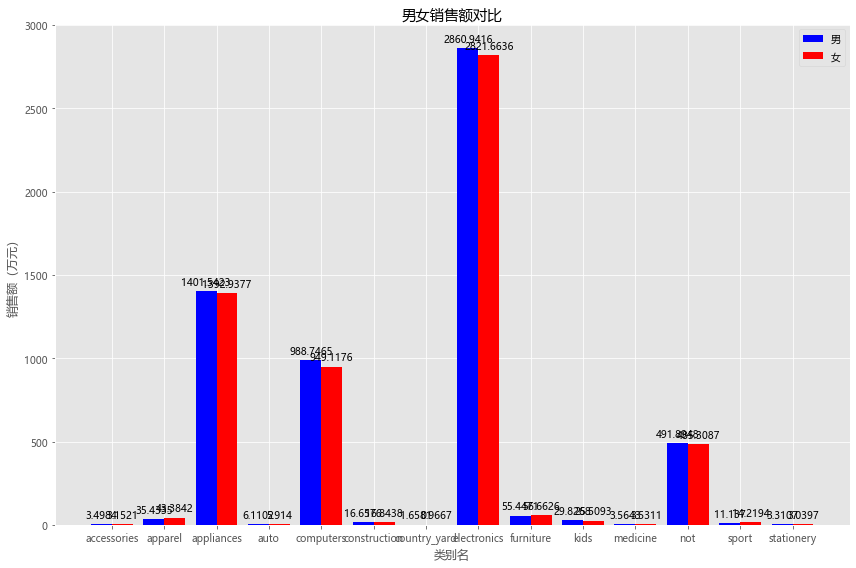

In [76]:
# 购买偏好
df3_temp = df3.groupby(['sex','category_code1'])['price'].sum().astype(int).sort_values().unstack(level=0)

a = df3_temp['男']
b = df3_temp['女']
a1 = {k: v / 10000 for k, v in a.items()}
b1 = {k: v / 10000 for k, v in b.items()}

x1 = list(a1.keys())
y1 = list(a1.values())
x2 = list(b1.keys())
y2 = list(b1.values())

x = np.arange(len(x1))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width / 2, y1, width, label='男',color = 'b')
rects2 = ax.bar(x + width / 2, y2, width, label='女',color = 'r')

# 设置图形属性
ax.set_xlabel('类别名')
ax.set_ylabel('销售额（万元）')
ax.set_title('男女销售额对比')
ax.set_xticks(x)
ax.set_xticklabels(x1)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 从图形上看,男女间的销售额并无太大区别


In [77]:
df3_temp['比例差额'] = round((df3_temp['女'] - df3_temp['男']) / df3_temp['女']*100).astype(int)
df3_temp.sort_values(by='比例差额')

df3.head()

,user_id,R,M,F,标签,RMF标签,event_time,order_id,product_id,category_id,...,sex,local,year,month,day,hour,weekday,category_code1,category_code2,category_code3
0,1515915625439951872.000000,135,416.640000,1,0,潜在客户,2020-07-09 06:35:18+00:00,2349284169969828321,1515966223509089779,2374498914000592384.000000,...,女,浙江,2020,7,9,6,4,electronics,video,tv
1,1515915625440038400.000000,24,56.430000,2,0,一般发展客户,2020-09-22 15:11:15+00:00,2388440981134512449,2273948227747185446,2268105410592374784.000000,...,男,北京,2020,9,22,15,2,kids,toys,not
2,1515915625440038400.000000,24,56.430000,2,0,一般发展客户,2020-10-28 05:53:47+00:00,2388440981134640159,1515966223520144221,2268105409048871168.000000,...,男,北京,2020,10,28,5,3,computers,network,router
3,1515915625440051712.000000,5,7530.340000,5,2,高价值客户,2020-10-21 12:23:18+00:00,2388440981134625646,2309018185069757002,2268105455169438720.000000,...,男,广东,2020,10,21,12,3,not,not,not
4,1515915625440051712.000000,5,7530.340000,5,2,高价值客户,2020-10-23 03:51:26+00:00,2388440981134632037,1515966223509104210,2374498914000592384.000000,...,男,广东,2020,10,23,3,5,electronics,video,tv


### 结合表格,在某些细分领域上,双方存在比较明显的差别.
### 在country_yard,kids,accessories,stationery 上,男性的消费力要强于女性.
### apparel,sport 上,男性的消费力要弱于女性.

## 2.年龄和购买力,购买偏好 (age)

In [78]:
# 年龄分布比较平均,结合现实情况,考虑按5年为一个集合将用户聚类
lis1 = [15,21,26,31,36,41,46]
lis2 = [21,26,31,36,41,46,51]
lis3 = [f"{a}-{b}年龄段" for a,b in zip(lis1,lis2)]
def check_age(x):
    if x > 45:
        return lis3[-1]
    elif x> 40:
        return lis3[-2]
    elif x> 35:
        return lis3[-3]
    elif x> 30:
        return lis3[-4]
    elif x> 25:
        return lis3[-5]
    elif x > 20:
        return lis3[-6]
    else:
        return lis3[0]
df3['age_label'] = df3.apply(lambda x:check_age(x['age']),axis=1)


In [79]:
a = df3.groupby('age')['price'].sum()

消费能力最高的五个年龄和消费金额 [(43.0, 383.570232), (32.0, 380.20384900000005), (48.0, 378.031832), (44.0, 373.36656800000003), (20.0, 370.59935)] 
消费能力最低的五个年龄段和金额 [(38.0, 303.683124), (37.0, 303.00264500000003), (19.0, 302.573936), (36.0, 300.532031), (39.0, 299.983647)]


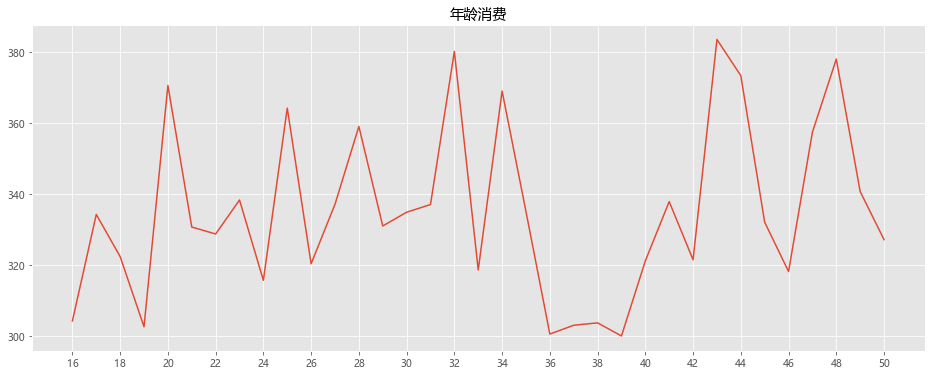

In [80]:
a = df3.groupby('age')['price'].sum()
a1 = {k:v/10000 for k,v in a.items()}

plt.figure(figsize=(16, 6))
plt.xticks(range(0,51,2))
           
x = a1.keys()
y = a1.values()
plt.title('年龄消费') 
# plt.xlabel('年龄段') 
# plt.ylabel('消费能力(万元)') 
plt.plot(x,y)

a2 = sorted(list(a1.items()),key=lambda x: x[1],reverse =True)
print('消费能力最高的五个年龄和消费金额',a2[:5],'\n消费能力最低的五个年龄段和金额',a2[-5:])

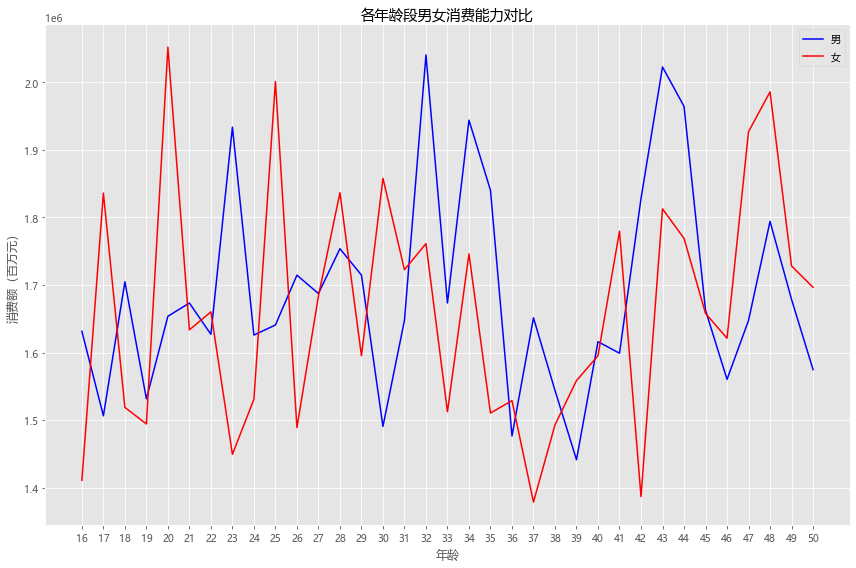

In [81]:
a = df3.groupby(['age','sex'])['price'].sum()
a1 = [i[1] for i in a.items() if '男' in i[0]]
a2 = [i[1] for i in a.items() if '女' in i[0]]

x1 = list(range(16,51))
y1 = list(a1)
x2 = list(range(16,51))
y2 = list(a2)

x = np.arange(len(x1))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 8))
# 绘制折线图
line1 = ax.plot(x, y1, label='男', color='b')
line2 = ax.plot(x, y2, label='女', color='r')

# 设置图形属性
ax.set_xlabel('年龄')
ax.set_ylabel('消费额（百万元）')
ax.set_title('各年龄段男女消费能力对比')
ax.set_xticks(x)
ax.set_xticklabels(x1)
ax.legend()

plt.tight_layout()
plt.show()

lis1 = {k: v for k, v in zip(x1, y1)}
lis2 = {k: v for k, v in zip(x2, y2)}


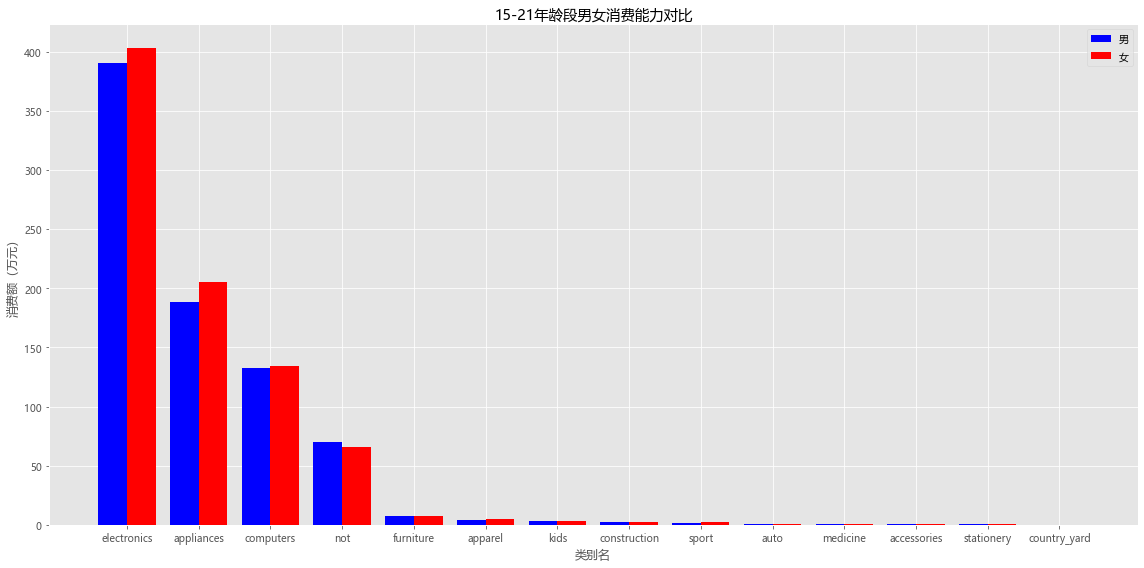

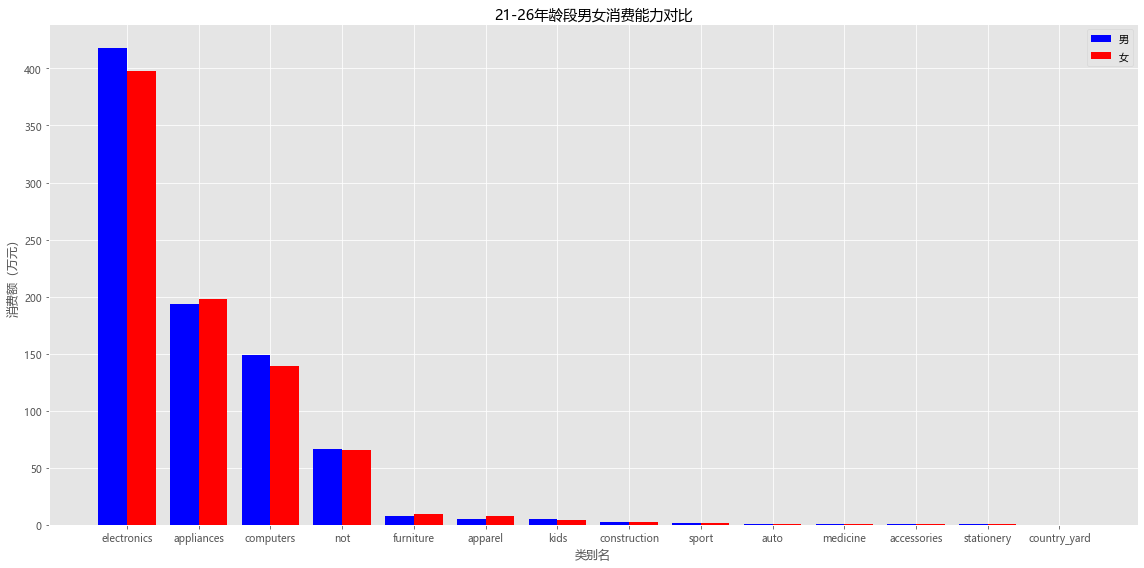

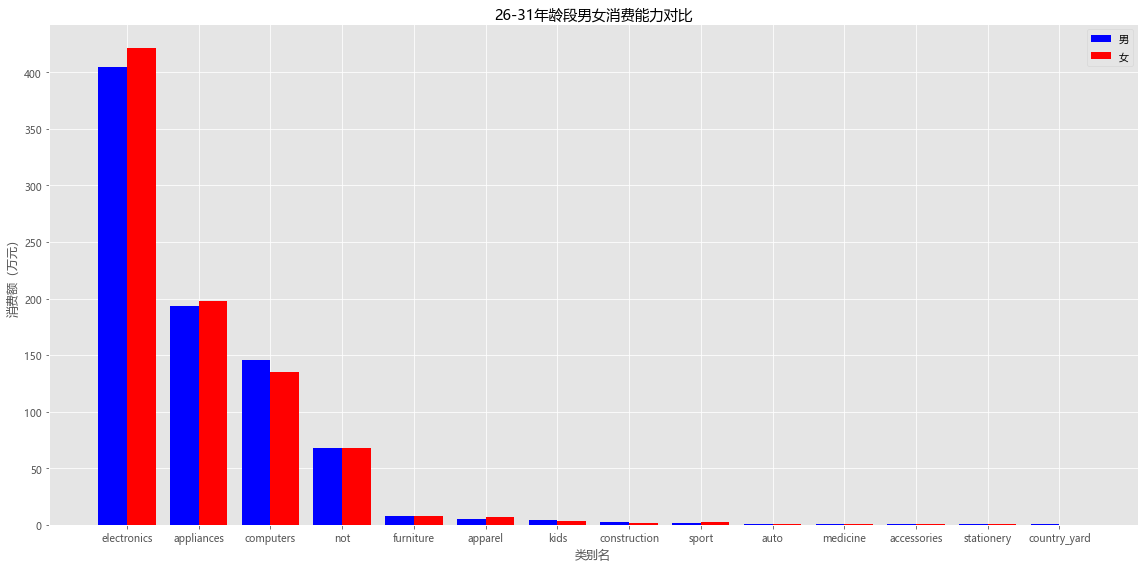

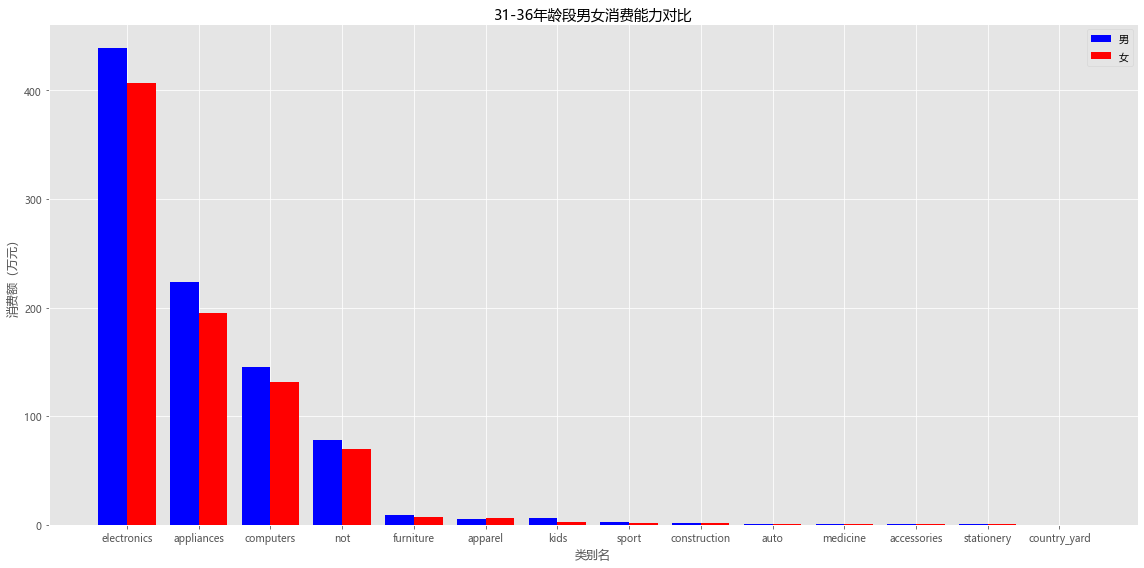

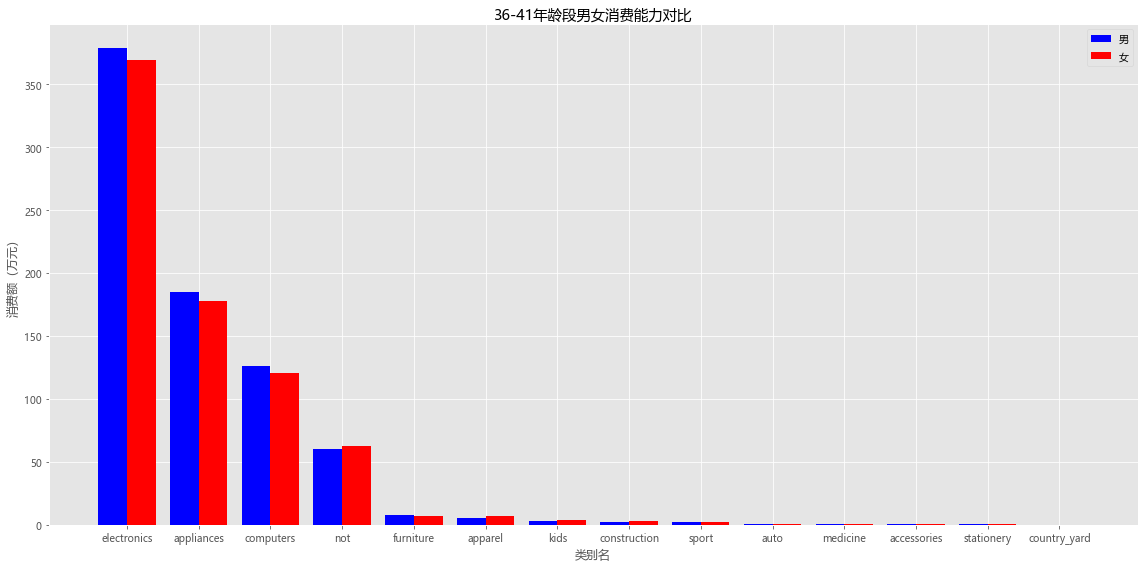

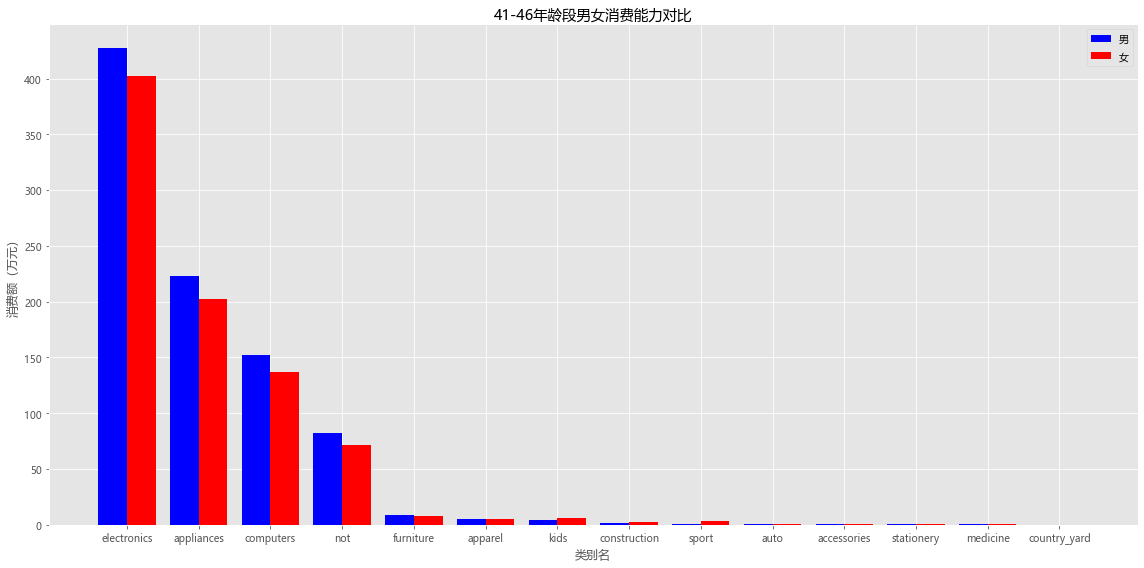

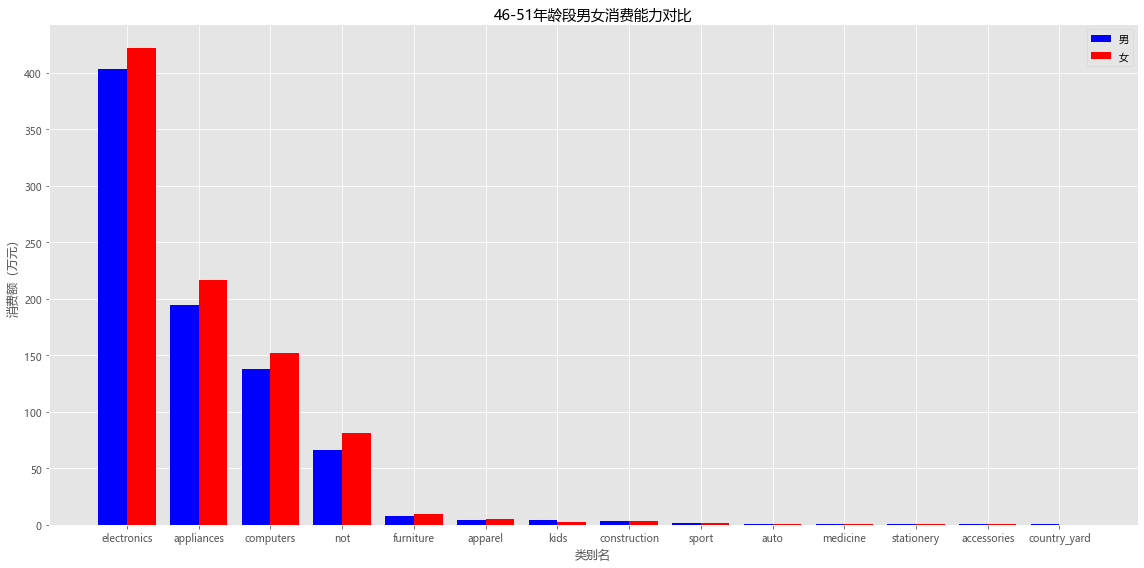

In [82]:
a = df3.groupby(['age_label','sex', 'category_code1'])['price'].sum().unstack(level=1)
a['total'] = a['男']+  a['女'] 
a = a.sort_values(by=['age_label','total'],ascending=[True, False])
lis = ['15-21年龄段','21-26年龄段','26-31年龄段','31-36年龄段','36-41年龄段','41-46年龄段','46-51年龄段']
for j in lis:
    
    a_ =  a['男'][j]
    b  =  a['女'][j]
    a1 = {k: v / 10000 for k, v in a_.items()}
    b1 = {k: v / 10000 for k, v in b.items()}

    x1 = list(a1.keys())
    y1 = list(a1.values())
    x2 = list(b1.keys())
    y2 = list(b1.values())

    x = np.arange(len(x1))
    width = 0.4

    fig, ax = plt.subplots(figsize=(16, 8))

    rects1 = ax.bar(x - width / 2, y1, width, label='男',color = 'b')
    rects2 = ax.bar(x + width / 2, y2, width, label='女',color = 'r')

    # 设置图形属性
    ax.set_xlabel('类别名')
    ax.set_ylabel('消费额（万元）')
    ax.set_title(f'{j}男女消费能力对比')
    ax.set_xticks(x)
    ax.set_xticklabels(x1)
    ax.legend()

    plt.tight_layout()
    plt.show()
        
        

41~46岁的男性用户在全品类的消费力普遍高于同龄女性用户。在46岁~50岁则是女性用户消费力高于同龄男性用户。
在31~36岁时，男性用户消费力高于女性用户。因此可以针对这些年龄段的不同性别采取不同的营销策略，刺激高消费的用户类型进行消费。

In [83]:
# 不同年龄的价值用户分布情况
df3_temp = df3.groupby(['sex','age_label', 'RMF标签'])['user_id'].nunique().unstack(level=1).astype(int)
df3_temp

# 如图,不同价值标签的用户在各年龄段,不同性别上的人数分布也相对平衡.人数出现差距时,也不会超过10%.因此暂不对年龄段和价值标签展开分析

age_label   15-21年龄段  21-26年龄段  26-31年龄段  31-36年龄段  36-41年龄段  41-46年龄段  \
sex RMF标签                                                                
女   一般价值客户        26        32        17        27        26        19   
    一般保持客户       137       135       126       124        98       149   
    一般发展客户       223       219       234       218       238       227   
    潜在客户        2967      2991      2984      3061      3071      3047   
    重点保持客户      1170      1225      1185      1251      1171      1184   
    重点发展客户       207       222       225       219       216       211   
    重点挽留客户      1775      1734      1758      1661      1700      1790   
    高价值客户        441       464       453       450       433       474   
男   一般价值客户        21        27        22        17        19        26   
    一般保持客户       137       128       132       140       139       120   
    一般发展客户       227       215       259       209       231       231   
    潜在客户        3019      3101      3065      3104      3017      3049   
    重点保持客户      1263      1207      1188      1128      1212      1239   
    重点发展客户       224       225       236       209       173       214   
    重点挽留客户      1682      1718      1732      1746      1761      1724   
    高价值客户        427       432       426       452       463       470   

age_label   46-51年龄段  
sex RMF标签             
女   一般价值客户        24  
    一般保持客户       118  
    一般发展客户       215  
    潜在客户        2914  
    重点保持客户      1140  
    重点发展客户       210  
    重点挽留客户      1682  
    高价值客户        470  
男   一般价值客户        15  
    一般保持客户       108  
    一般发展客户       225  
    潜在客户        2987  
    重点保持客户      1194  
    重点发展客户       192  
    重点挽留客户      1780  
    高价值客户        440

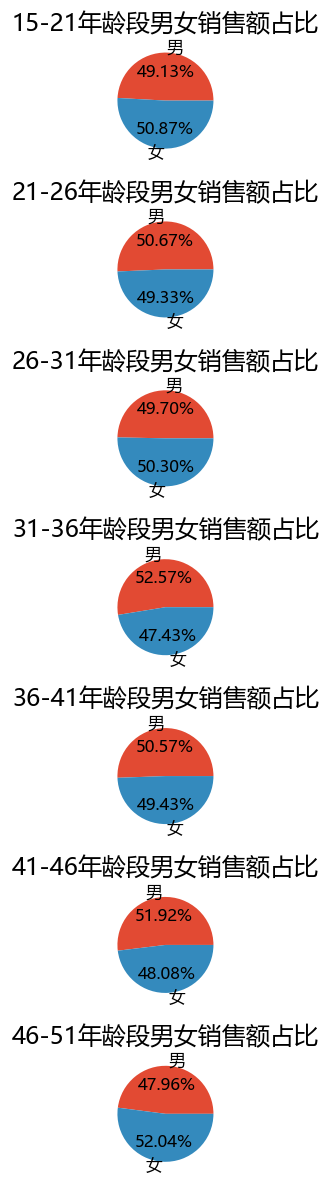

In [84]:
# 购买偏好
df3_temp = df3.groupby(['sex','age_label'])['price'].sum().astype(int).sort_values().unstack(level=0)
lis = ['15-21年龄段','21-26年龄段','26-31年龄段','31-36年龄段','36-41年龄段','41-46年龄段','46-51年龄段']
fig, ax, = plt.subplots(len(lis), 1, figsize=(20, 10),dpi = 120)

for j in range(len(lis)):
    a = [df3_temp['男'][lis[j]], df3_temp['女'][lis[j]]]
    a1 = [i/sum(a) for i in a]
    b1 = ['男','女']
    
    ax[j].pie(a1,labels=b1,autopct='%1.2f%%')
    ax[j].set_title(f'{lis[j]}男女销售额占比')

plt.tight_layout()
plt.show()


综合来看,
1.男性用户在23,32,34,43,44岁消费能力比其他年龄段更强.17,19,30,36,39岁比其他年龄段更弱.
2.女性用户在20,25,30,47,48岁消费能力比其他年龄段更强.16,23,26,37,42岁比其他年龄段更弱.

如果把把5年视作一个区间的话,
3.男性在31-36,36-41这10年间消费能力最强.15-21,36-41这10年消费能力最弱.
4.女性在26-31,46-51这10年间消费能力最强.31-36,36-41这10年消费能力最弱.

如果不区分性别16-20岁和36-41岁的用户消费能力比较弱.31-36和40岁以后消费能力比较强.可以针对上述高消费年龄段的用户进行需求挖掘。

# 3.地域和购买力,购买偏好 (local)

In [85]:
df3.groupby('local')['price'].sum().sort_values( ascending= False)

local
广东   25999875.090000
上海   19817768.190000
北京   19066955.140000
湖南    6981796.090000
海南    6966574.830000
四川    6769440.560000
浙江    6519561.570000
重庆    6463185.720000
天津    6430335.120000
江苏    6330488.780000
湖北    5974224.080000
Name: price, dtype: float64

In [86]:
df3_g = df3.groupby(['local','RMF标签'])['user_id'].agg('nunique').sort_values( ascending= False).unstack(level=1).astype(int)

df3_g['total'] = df3_g.apply(sum,axis=1)
df3_g1 = df3_g.apply(lambda x: round(x / x['total'],4), axis=1)
df3_g1.sort_values( by='total',ascending= False)
# 从标签分布和总人数上来看,各地区的标签分布相对平衡.
# 平台客户以广东,上海,北京的用户为主.

RMF标签,一般价值客户,一般保持客户,一般发展客户,潜在客户,重点保持客户,重点发展客户,重点挽留客户,高价值客户,total
local,,,,,,,,,
上海,0.003600,0.017100,0.031300,0.436800,0.167200,0.033200,0.247500,0.063300,1.000000
北京,0.002500,0.019500,0.032300,0.432400,0.169200,0.028600,0.252100,0.063400,1.000000
四川,0.002900,0.017600,0.036100,0.442600,0.167300,0.029400,0.238100,0.066100,1.000000
天津,0.003500,0.016100,0.031300,0.420900,0.178900,0.032300,0.251100,0.065800,1.000000
广东,0.003100,0.019800,0.031600,0.435500,0.168300,0.028300,0.248100,0.065400,1.000000
江苏,0.004300,0.016300,0.035100,0.428700,0.168400,0.036900,0.247700,0.062500,1.000000
浙江,0.004100,0.013600,0.034500,0.433300,0.174100,0.030800,0.246900,0.062800,1.000000
海南,0.003600,0.018900,0.029000,0.428500,0.180100,0.026500,0.251300,0.062100,1.000000
湖北,0.002600,0.017600,0.035000,0.422000,0.175600,0.032400,0.253800,0.060800,1.000000


In [87]:
# df3.groupby(['local','sex','age'])['price'].sum().sort_values( ascending= False)
map_list = df3.groupby(['local'])['user_id'].nunique().sort_values( ascending= False).reset_index()
map_list.columns=['地域','用户数']
map_list

,地域,用户数
0,广东,21636
1,上海,16253
2,北京,16121
3,江苏,5635
4,四川,5518
5,海南,5508
6,浙江,5428
7,重庆,5396
8,天津,5393
9,湖北,5393


平台用户来自北上广。

In [88]:
df3_g = df3.groupby(['local','age_label'])['user_id'].agg('nunique').sort_values( ascending= False).unstack(level=1).astype(int)


df3_g['total'] = df3_g.apply(sum,axis=1)
df3_g1 = df3_g.apply(lambda x: round(x / x['total'],4), axis=1)
df3_g1.sort_values( by='total',ascending= False)

age_label,15-21年龄段,21-26年龄段,26-31年龄段,31-36年龄段,36-41年龄段,41-46年龄段,46-51年龄段,total
local,,,,,,,,
上海,0.142800,0.148600,0.145300,0.141700,0.138800,0.145600,0.137100,1.000000
北京,0.144900,0.143100,0.142300,0.141600,0.142600,0.144700,0.140800,1.000000
四川,0.146500,0.146100,0.150500,0.140500,0.142000,0.137600,0.136700,1.000000
天津,0.141900,0.140600,0.140400,0.140700,0.150000,0.140900,0.145600,1.000000
广东,0.140600,0.142400,0.142000,0.144800,0.145000,0.144300,0.140800,1.000000
江苏,0.138400,0.144800,0.140400,0.148700,0.141900,0.151500,0.134300,1.000000
浙江,0.144500,0.149700,0.142000,0.136600,0.137600,0.147500,0.142100,1.000000
海南,0.140800,0.142300,0.152200,0.138700,0.137400,0.144500,0.144100,1.000000
湖北,0.136900,0.142400,0.140400,0.143400,0.143700,0.144500,0.148700,1.000000


In [89]:
df3_g = df3.groupby(['local','sex'])['user_id'].agg('nunique').sort_values( ascending= False).unstack(level=1).astype(int)

df3_g['总人数'] = df3_g.apply(sum,axis=1)
df3_g.sort_values( by='总人数',ascending= False)

sex,女,男,总人数
local,,,
广东,10799,10937,21736
上海,8085,8236,16321
北京,8039,8152,16191
江苏,2791,2849,5640
四川,2689,2843,5532
海南,2757,2761,5518
浙江,2686,2752,5438
重庆,2763,2643,5406
湖北,2723,2675,5398


In [90]:
df3.columns

Index(['user_id', 'R', 'M', 'F', '标签', 'RMF标签', 'event_time', 'order_id',
       'product_id', 'category_id', 'category_code', 'brand', 'price', 'age',
       'sex', 'local', 'year', 'month', 'day', 'hour', 'weekday',
       'category_code1', 'category_code2', 'category_code3', 'age_label'],
      dtype='object')

In [91]:
df3_g = df3.groupby(['local'])['category_code1'].value_counts().unstack()
df3_g['total'] = df3_g.apply(sum,axis=1)
df3_g1 = df3_g.apply(lambda x: round(x / x['total'],4), axis=1)

In [92]:
df3_g1

category_code1,accessories,apparel,appliances,auto,computers,construction,country_yard,electronics,furniture,kids,medicine,not,sport,stationery,total
local,,,,,,,,,,,,,,,
上海,0.005600,0.004400,0.269700,0.002200,0.136000,0.007600,0.000300,0.281100,0.042800,0.004300,0.001900,0.226900,0.001800,0.015500,1.000000
北京,0.005500,0.004900,0.270800,0.002400,0.134800,0.006900,0.000300,0.275500,0.043700,0.003900,0.001800,0.231800,0.001700,0.015900,1.000000
四川,0.005900,0.003700,0.265300,0.002200,0.137400,0.007100,0.000500,0.277000,0.045200,0.003500,0.002300,0.233500,0.001400,0.015100,1.000000
天津,0.004900,0.004100,0.264400,0.002300,0.143200,0.005100,0.000300,0.280100,0.043400,0.005400,0.001700,0.227600,0.001900,0.015700,1.000000
广东,0.005300,0.004700,0.264400,0.002200,0.137200,0.007300,0.000400,0.286500,0.043200,0.003900,0.002100,0.225000,0.001300,0.016400,1.000000
江苏,0.005500,0.006200,0.259600,0.002800,0.139800,0.006700,0.000200,0.286000,0.042200,0.004800,0.002600,0.227700,0.001900,0.013900,1.000000
浙江,0.005500,0.005200,0.268200,0.003900,0.133500,0.006000,0.000300,0.283800,0.043800,0.004000,0.002100,0.227200,0.001300,0.015200,1.000000
海南,0.005000,0.005400,0.263300,0.002600,0.131600,0.007400,0.000400,0.272200,0.047500,0.004000,0.002100,0.241900,0.001200,0.015600,1.000000
湖北,0.005100,0.004300,0.270300,0.002400,0.145500,0.008200,0.000300,0.296800,0.035800,0.004500,0.002300,0.208400,0.002100,0.014000,1.000000


In [93]:
# 根据地域分类的各项指标分布比较都比较平均，各个分类的占比大致符合地域的人数比例。高低差额在3%以内。
# 并没有出现因地域不同，而出现对某一类商品的特别偏好这种情况。因此并无太多参考价值。

# 总结
1.平台销售数据统计  
平台畅销商品类型是 electronics，appliances，computers。占了整个平台销售额和销售数量的90%以上。其它品类的商品对用户吸引程度低。
平台销售额和普通用户数量、回流用户数量的相关性大于新增用户的相关性。提高销售额可以考虑通过提高普通用户和回流用户的购买频次。因为缺少登录数据，所以无法确定流失用户是经常登录，但无购买需求而不购买，还是不登陆。

2.用户活跃程度分层和每日新增用户统计  
用户粘性较差，有80%的用户在平台购物1次后便流失。应该挖掘用户的购买需求，提高用户粘性。
用户的下单高峰期是5点~13点。客服或其他配套服务人员可以考虑增加资源，确保在高峰期的用户体验。

3.用户消费偏好和关联推荐    
根据已有用户订单聚类。输出每类商品相关性最高的5个商品标签。可以根据标签做相关推荐。

4.不同标签和购买力的关系分析  
性别、地域和用户购买力之间不存在相关性。大于40岁的用户比其他年龄段的用户消费金额更大。36~41岁的用户消费意愿最低。总体而言，用户在这几个维度并不存在明显区别。